In [1]:
import os
import theano
import lasagne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer

Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, CuDNN not available)
/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
!pip freeze | grep "Theano\|Lasagne\|pandas\|scikit-learn\|matplotlib\|nolearn"

Lasagne==0.2.dev1
matplotlib==2.0.2
nolearn==0.6.0
pandas==0.20.3
scikit-learn==0.19.0
Theano==0.8.0


### Network structure

#### Setup all the layers and parameters

In [5]:
layers_0 = [
                (InputLayer, {'shape': (None, 1, 96, 96)}),
                (Conv2DLayer, {'num_filters': 32, 'filter_size': (4, 4)}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.1}),
                (Conv2DLayer, {'num_filters': 64, 'filter_size': (2, 2)}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.2}),
                (Conv2DLayer, {'num_filters': 128, 'filter_size': (2, 2)}),
                (MaxPool2DLayer, {'pool_size': 2}),        
                (DropoutLayer, {'p': 0.3}),
                (DenseLayer, {'num_units': 1500}),
                (DropoutLayer, {}),
                (DenseLayer, {'num_units': 1500}),
                (DenseLayer, {'num_units': 90, 'nonlinearity': None})
        ]

In [3]:
class FlipBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        """
        Flip randomly half of the images and their associated landmarks
        """
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs/2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            yb[indices, ::2] = yb[indices, ::2] * -1

        return Xb, yb

class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

# This two classes where taken from https://github.com/dnouri/kfkd-tutorial/blob/master/kfkd.py

In [26]:
def create_network(npochs=1000, batch_s=178):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.08)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=True,
        batch_iterator_train=FlipBatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.08, stop=0.001),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)
net0 = create_network()

### Testing of already trained networks

#### Load images from csv (already preproc done)

In [6]:
def load_data(fname='files/96x96_no_index.csv'):
    """
    The file format is x00,y00,x01,y01, ..... x44, y44, Image
    Where x, y are the manual coordinates to landmarks and
    semilandmarks.
    
    """
    df = pd.read_csv(fname)
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(str(im), sep=' '))
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    names = df['Id']

    return X, names

X, names = load_data("files/orejas_ietspecial.csv")
X = X.reshape(-1, 1, 96, 96)

#### Load trained network

In [7]:
import pickle
import sys
sys.setrecursionlimit(100000)

In [8]:
with open("../ears/ear_ultron/small_learn_rate_96x96_ear_fullface.pickle", 'rb') as f:
        net = pickle.load(f, encoding='latin1')

#### Check structure of the loaded *net*

In [17]:
net.layers_

Layers([('input0', <lasagne.layers.input.InputLayer at 0x7f2b3ecb4828>),
        ('conv2d1', <lasagne.layers.conv.Conv2DLayer at 0x7f2b3ecb47f0>),
        ('maxpool2d2', <lasagne.layers.pool.MaxPool2DLayer at 0x7f2b3ecb47b8>),
        ('dropout3', <lasagne.layers.noise.DropoutLayer at 0x7f2b3ecb4748>),
        ('conv2d4', <lasagne.layers.conv.Conv2DLayer at 0x7f2b3ecb4710>),
        ('maxpool2d5', <lasagne.layers.pool.MaxPool2DLayer at 0x7f2b3ecb46d8>),
        ('dropout6', <lasagne.layers.noise.DropoutLayer at 0x7f2b3ecb4668>),
        ('conv2d7', <lasagne.layers.conv.Conv2DLayer at 0x7f2b3ecb45f8>),
        ('maxpool2d8', <lasagne.layers.pool.MaxPool2DLayer at 0x7f2b3ecb4588>),
        ('dropout9', <lasagne.layers.noise.DropoutLayer at 0x7f2b3ecb4518>),
        ('dense10', <lasagne.layers.dense.DenseLayer at 0x7f2b3ecb44e0>),
        ('dropout11', <lasagne.layers.noise.DropoutLayer at 0x7f2b3f3f07b8>),
        ('dense12', <lasagne.layers.dense.DenseLayer at 0x7f2b7c7112b0>),
        

#### Generate random black boxes to occlude parts of the image.

In [94]:
import numpy as np

box_size = 15
box = np.array([0.]*box_size*box_size).reshape(box_size, box_size)

for i in range(X.shape[0]):
    img = X[i].reshape(96, 96)
    x, y = np.random.randint(0,96-box_size, size=2)
    img[x:x+box_size, y:y+box_size] = box
    X[i] = img.reshape(-1, 1, 96, 96)

#### Load xml files for ground truth of each image

In [9]:
import xmltodict

In [10]:
root_folder = 'files/ground_box_truth/'
df = pd.DataFrame(columns=('id', 'xmin', 'ymin', 'xmax', 'ymax', 'object_class'))
for i in range(df.shape[1]):
    for i, xml_file in enumerate(os.listdir(root_folder)):
        #print os.path.join(root_folder, xml_file)
        with open(os.path.join(root_folder, xml_file)) as fd:
            doc = xmltodict.parse(fd.read())
            df.loc[i] = [doc['annotation']['filename'], float(doc['annotation']['object']['bndbox']['xmin']),
                        float(doc['annotation']['object']['bndbox']['ymin']), float(doc['annotation']['object']['bndbox']['xmax']),
                        float(doc['annotation']['object']['bndbox']['ymax']), doc['annotation']['object']['name']]
df.to_csv('files/lubliana_db_with_roi.csv')

#### Plot ground truth ROI with images

In [11]:
import matplotlib.patches as patches

In [12]:
def plot_ground_truth(ax, ground_truth):
    # ground_truth [x_min, y_min, x_max, y_max]
    width = float(ground_truth[2]) - float(ground_truth[0])
    height = float(ground_truth[3]) - float(ground_truth[1])
    ax.add_patch( patches.Rectangle((ground_truth[0], ground_truth[1]), width, height, color='m', fill=False))
      
    

In [13]:
def plot_sample(img, y, axis, move=48):
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * move + move, y[1::2] * move + move, marker='x', s=5)

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


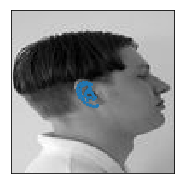

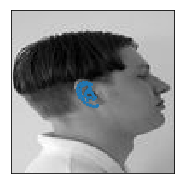

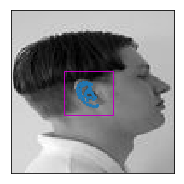

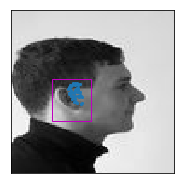

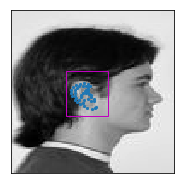

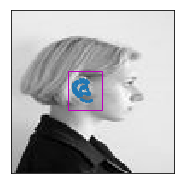

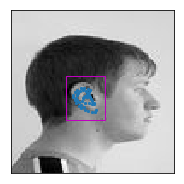

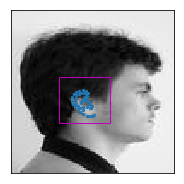

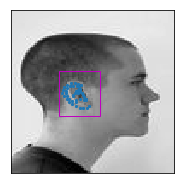

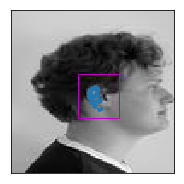

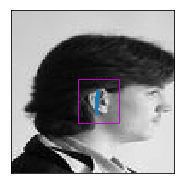

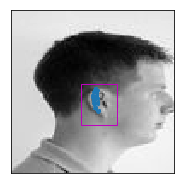

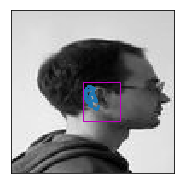

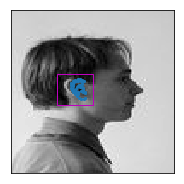

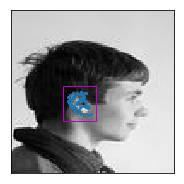

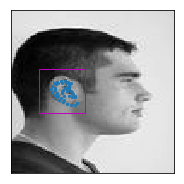

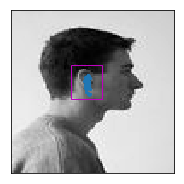

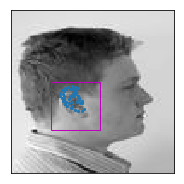

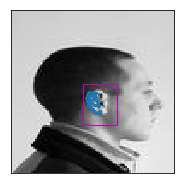

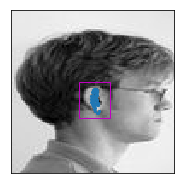

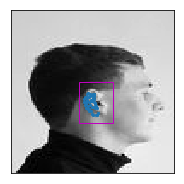

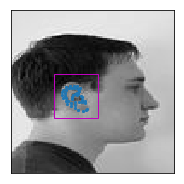

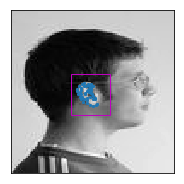

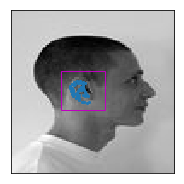

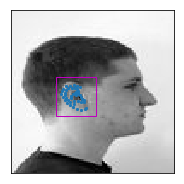

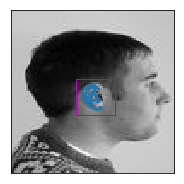

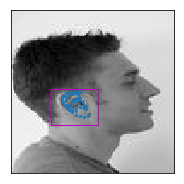

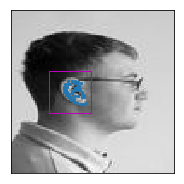

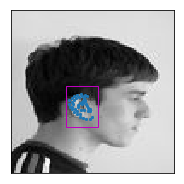

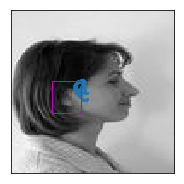

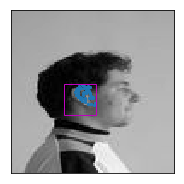

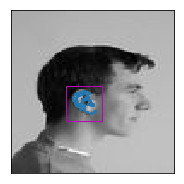

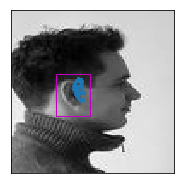

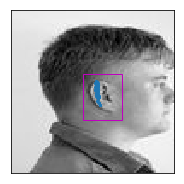

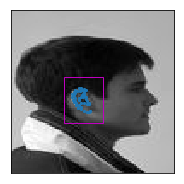

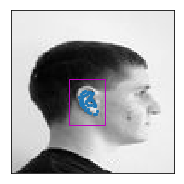

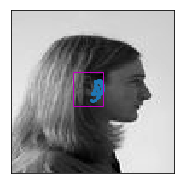

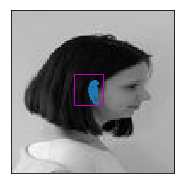

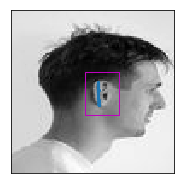

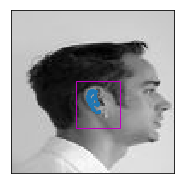

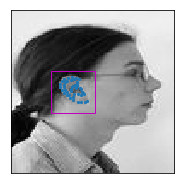

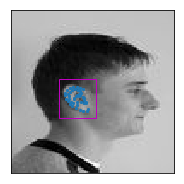

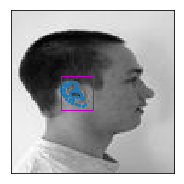

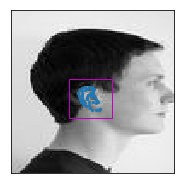

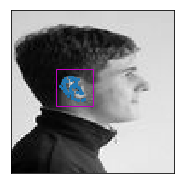

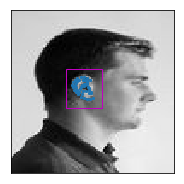

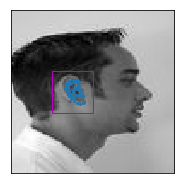

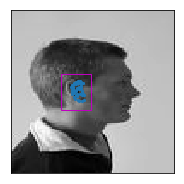

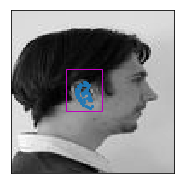

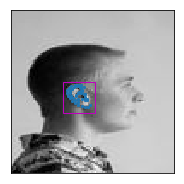

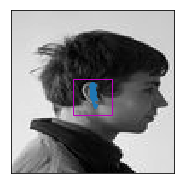

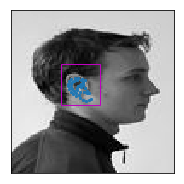

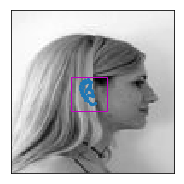

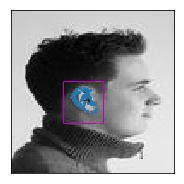

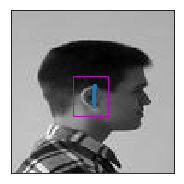

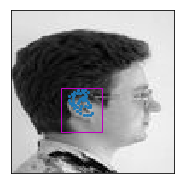

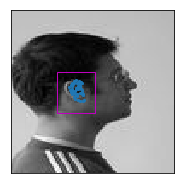

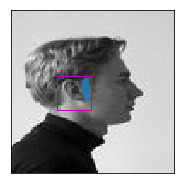

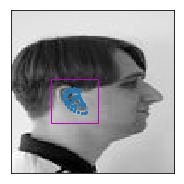

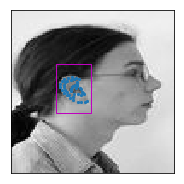

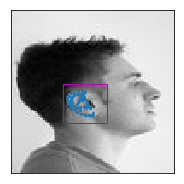

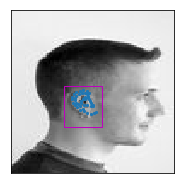

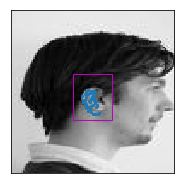

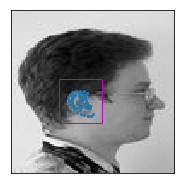

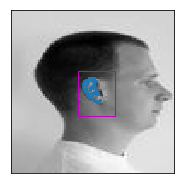

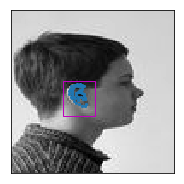

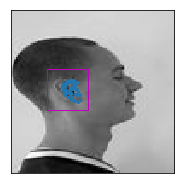

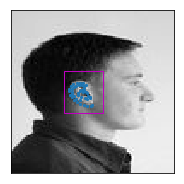

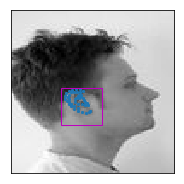

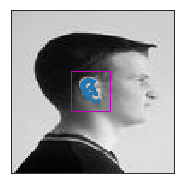

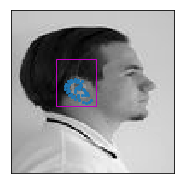

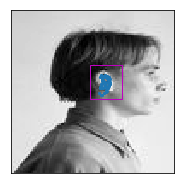

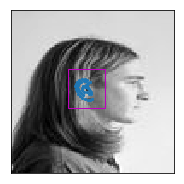

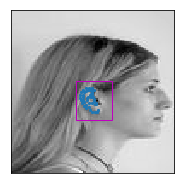

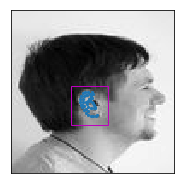

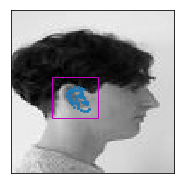

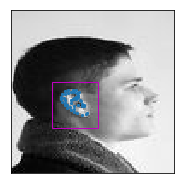

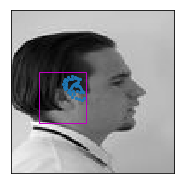

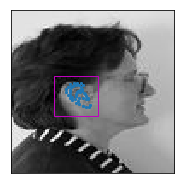

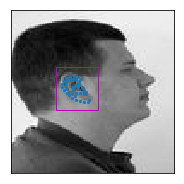

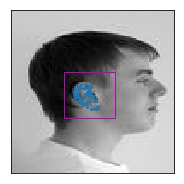

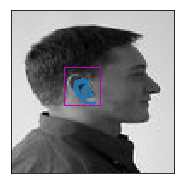

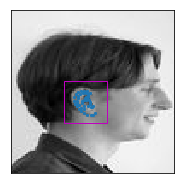

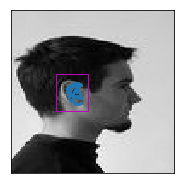

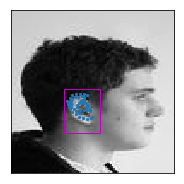

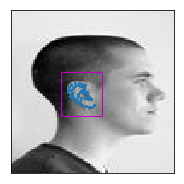

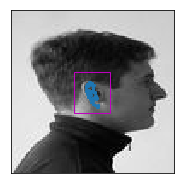

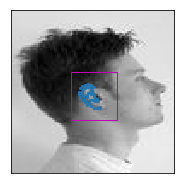

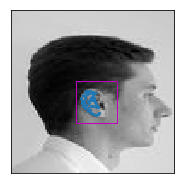

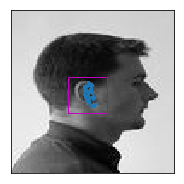

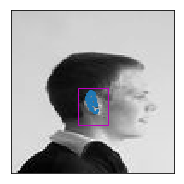

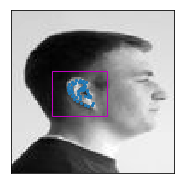

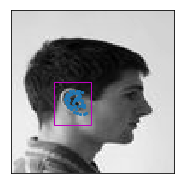

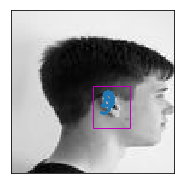

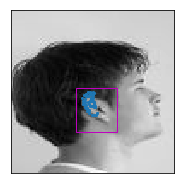

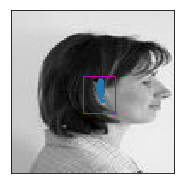

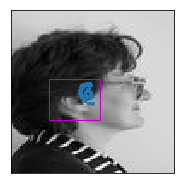

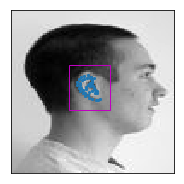

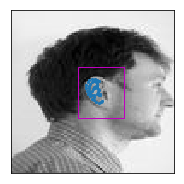

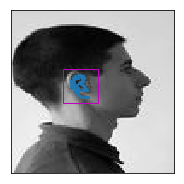

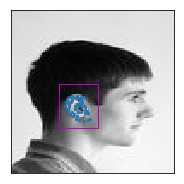

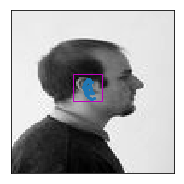

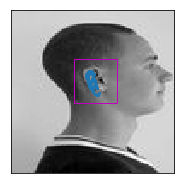

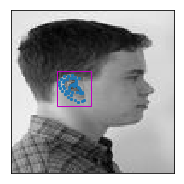

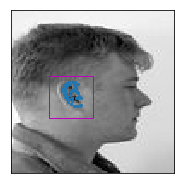

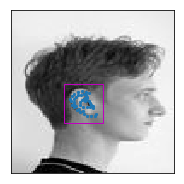

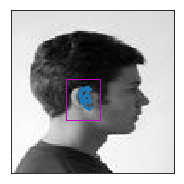

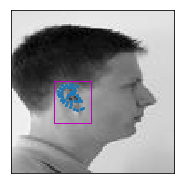

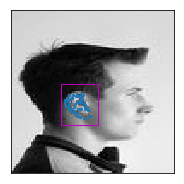

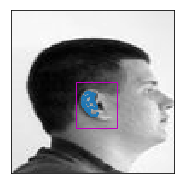

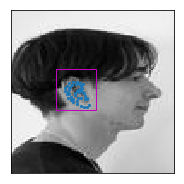

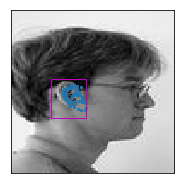

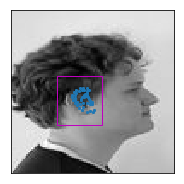

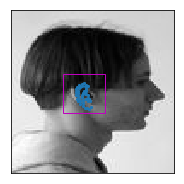

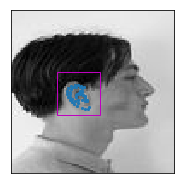

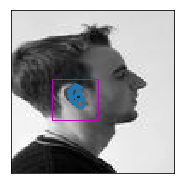

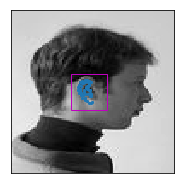

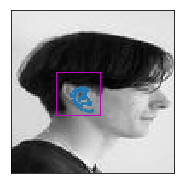

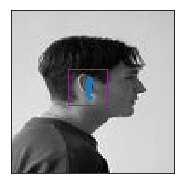

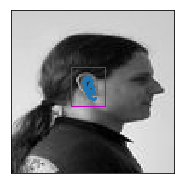

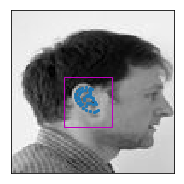

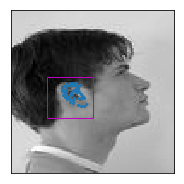

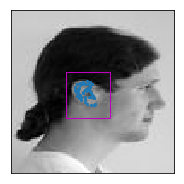

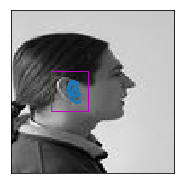

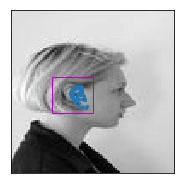

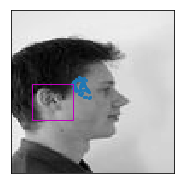

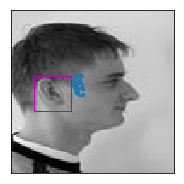

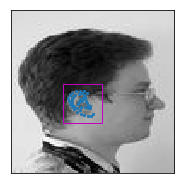

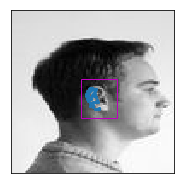

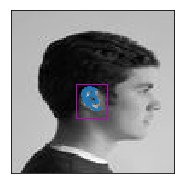

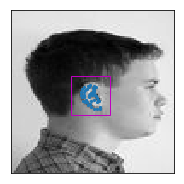

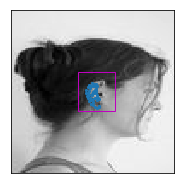

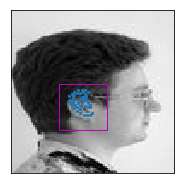

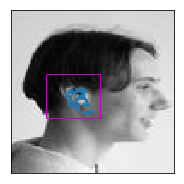

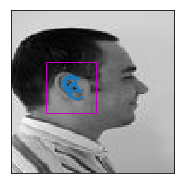

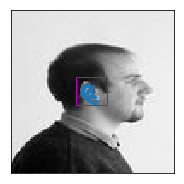

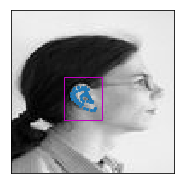

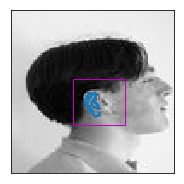

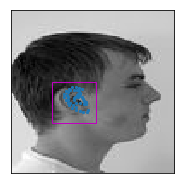

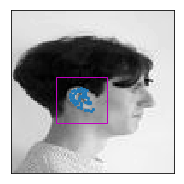

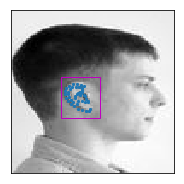

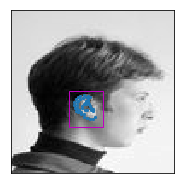

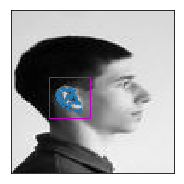

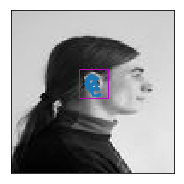

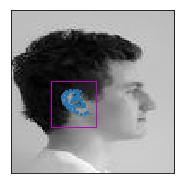

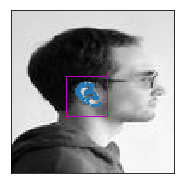

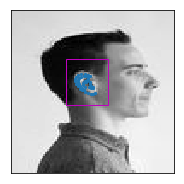

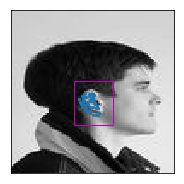

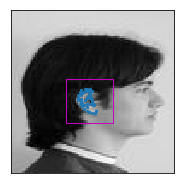

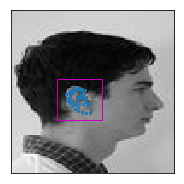

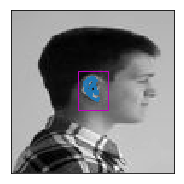

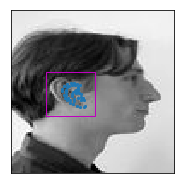

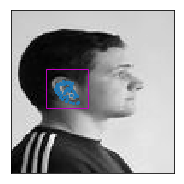

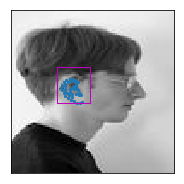

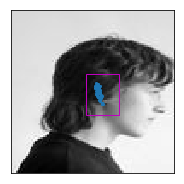

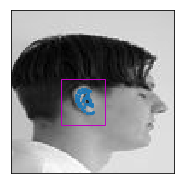

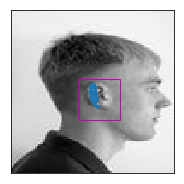

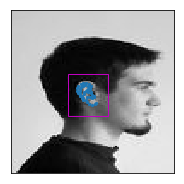

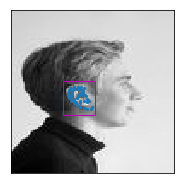

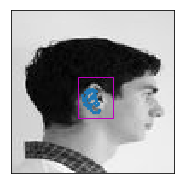

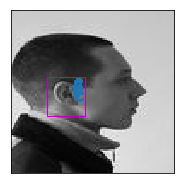

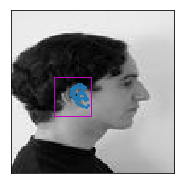

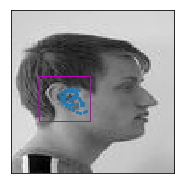

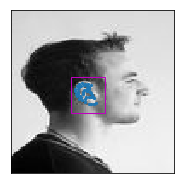

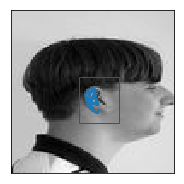

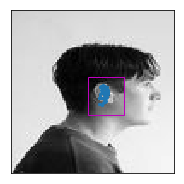

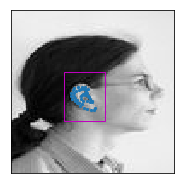

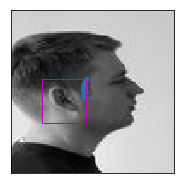

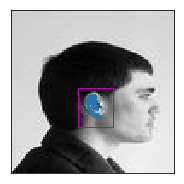

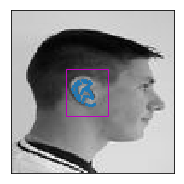

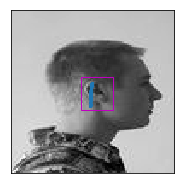

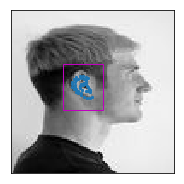

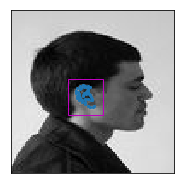

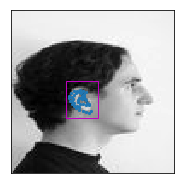

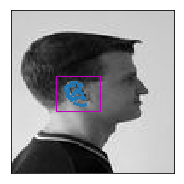

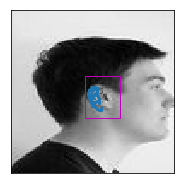

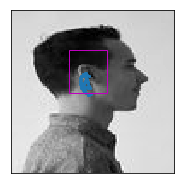

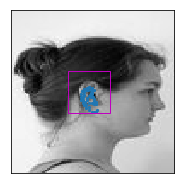

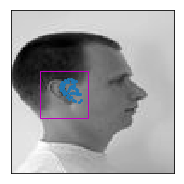

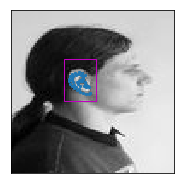

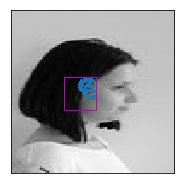

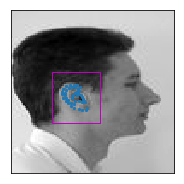

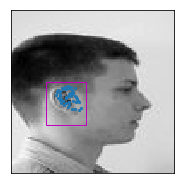

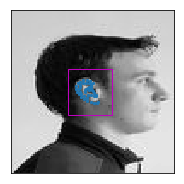

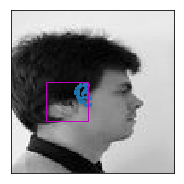

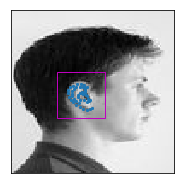

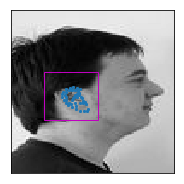

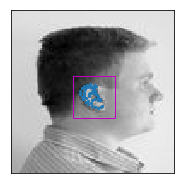

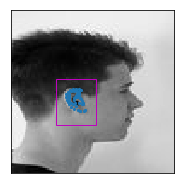

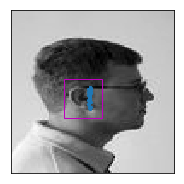

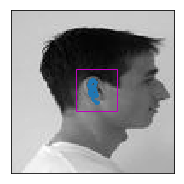

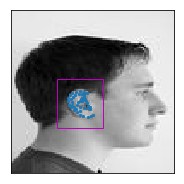

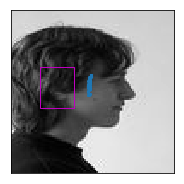

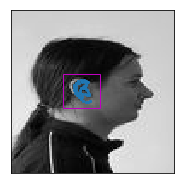

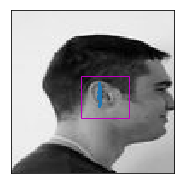

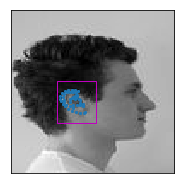

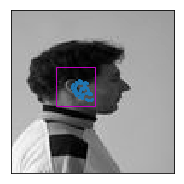

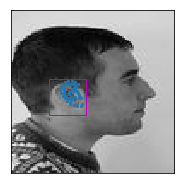

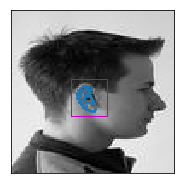

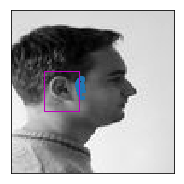

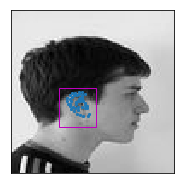

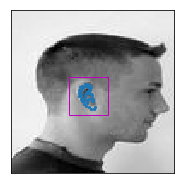

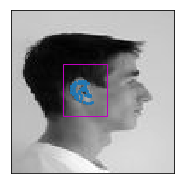

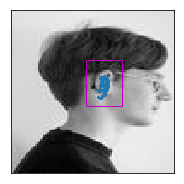

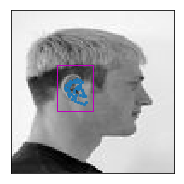

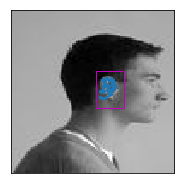

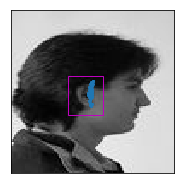

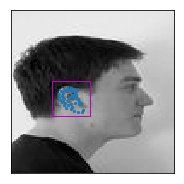

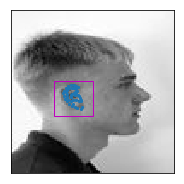

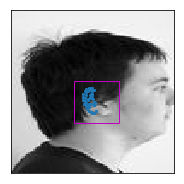

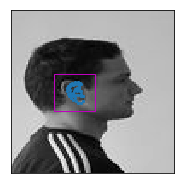

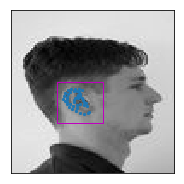

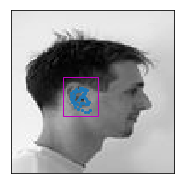

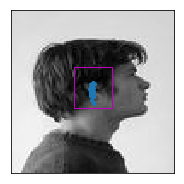

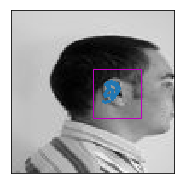

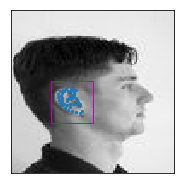

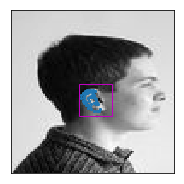

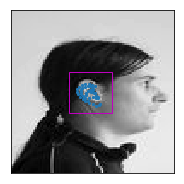

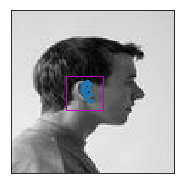

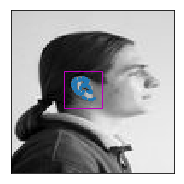

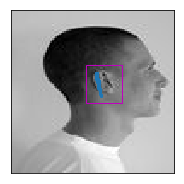

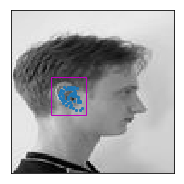

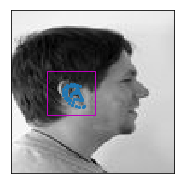

In [103]:
y_pred = net.predict(X)

for i in range(X.shape[0]):
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    img = X[i].reshape(96, 96)
    plot_sample(img, y_pred[i], ax)
    bnd_box = df[df['id'] == names[i]].values[0][1:-1]
    plot_ground_truth(ax, bnd_box)
    #plt.savefig('/tmp/out_lateral_{}.png'.format(str(names[i])))
plt.show()

#### Check if all the landmark's coordinates are inside of the ROI (ground truth)

In [14]:
def bound(x_points, y_points, xmin, ymin, xmax, ymax):
    """ """
    bound_x = np.logical_and(x_points > xmin, x_points < xmax)
    bound_y = np.logical_and(y_points > ymin, x_points < ymax)
    
    bb_filter = np.logical_and(bound_x, bound_y)
    return bb_filter

In [16]:
move = 48
TP = 0
y_pred = net.predict(X)
for i in range( X.shape[0]): 
    points_x = y_pred[i][0::2] * move + move
    points_y = y_pred[i][1::2] * move + move
    bnd_box = df[df['id'] == names[i]].values[0][1:-1]
    # [x_min, y_min, x_max, y_max]
    inside_box = bound(points_x, points_y, bnd_box[0], bnd_box[1], bnd_box[2], bnd_box[3])
    if inside_box.all():
        TP += 1
print('{} number of images with landmarks inside the ROI of {} Images'.format(TP, X.shape[0]))       

208 number of images with landmarks inside the ROI of 221 Images


#### Convex Hull Analysis

In [15]:
from scipy.spatial import ConvexHull

Area of the convex hull is 0.8636087607870845


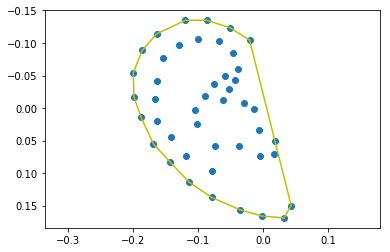

Area of the convex hull is 0.6999671329147957


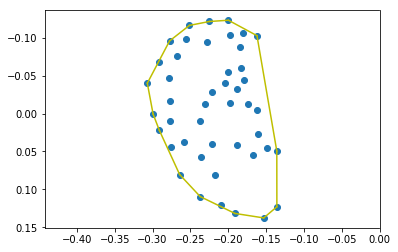

Area of the convex hull is 0.9726958782218039


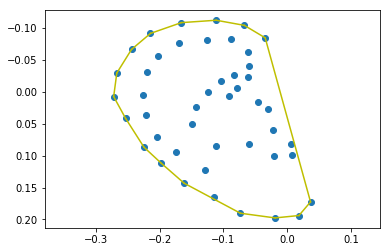

Area of the convex hull is 0.7821452558539816


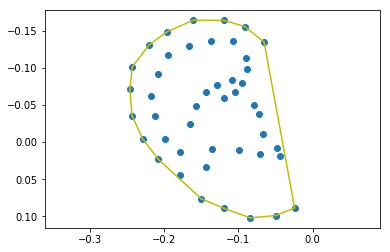

Area of the convex hull is 0.9061991701539279


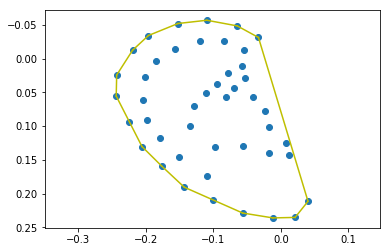

Area of the convex hull is 0.9209204056943101


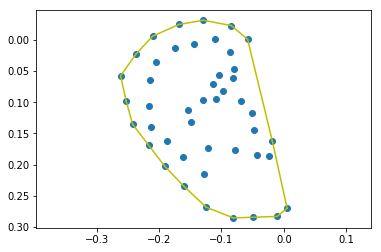

Area of the convex hull is 0.9868721343527592


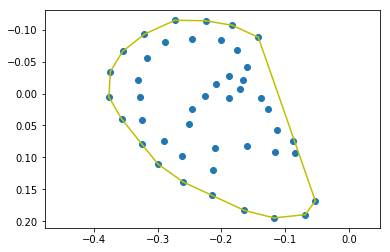

Area of the convex hull is 0.723063618600637


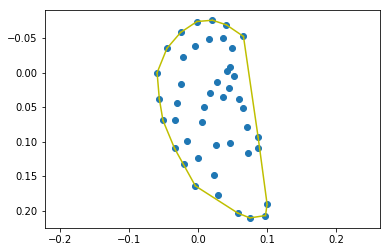

Area of the convex hull is 0.5567952324395998


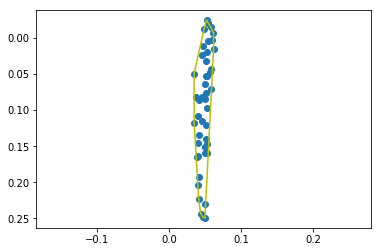

Area of the convex hull is 0.6377084018412998


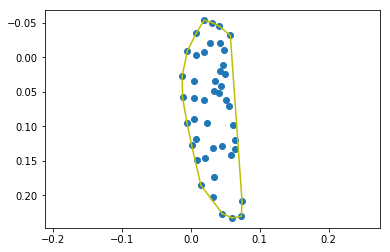

Area of the convex hull is 0.7148076447060068


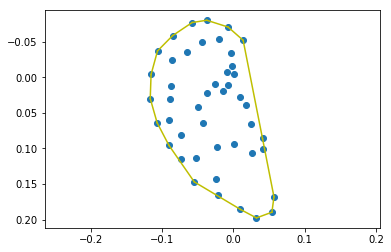

Area of the convex hull is 0.6875108827361486


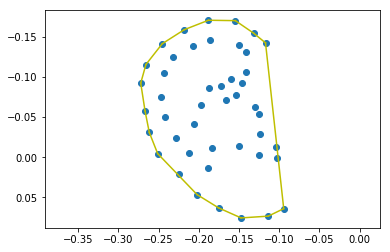

Area of the convex hull is 0.8950396301024482


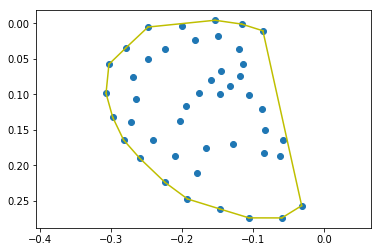

Area of the convex hull is 0.9751837054429098


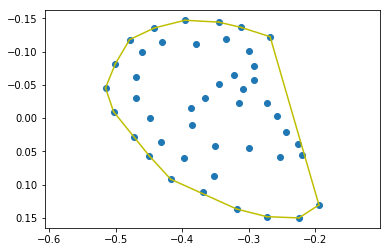

Area of the convex hull is 0.5424728829718952


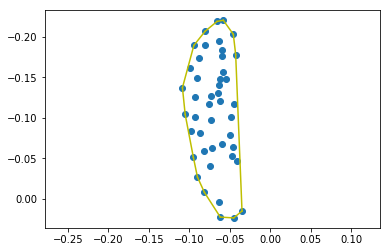

Area of the convex hull is 0.9373735220787954


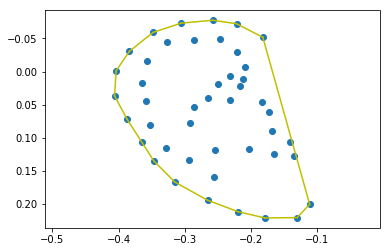

Area of the convex hull is 0.6919079896325429


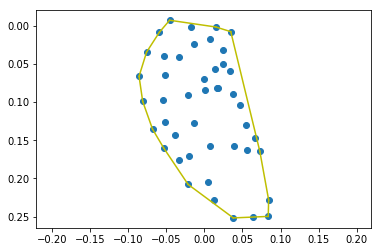

Area of the convex hull is 0.6568118754702645


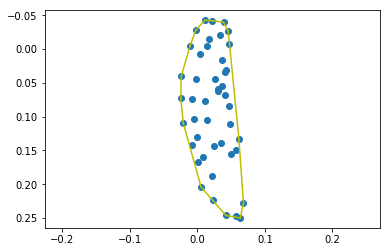

Area of the convex hull is 0.7093464914218981


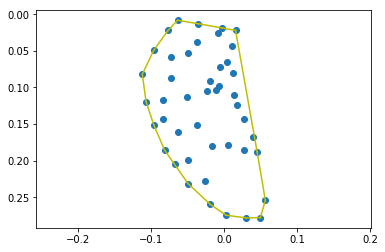

Area of the convex hull is 0.9643047703354561


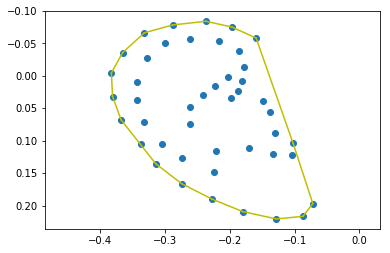

Area of the convex hull is 0.815960763029819


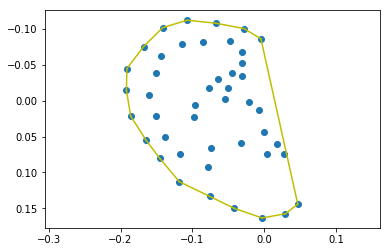

Area of the convex hull is 0.781542031023827


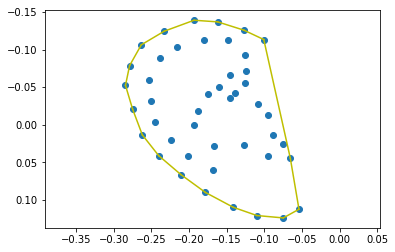

Area of the convex hull is 0.9476924272767939


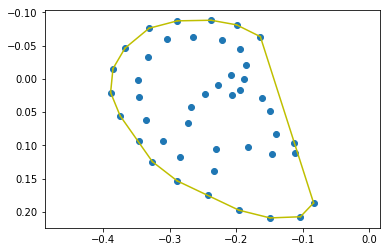

Area of the convex hull is 0.8267728597079225


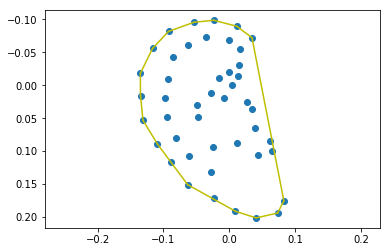

Area of the convex hull is 1.0195150505411292


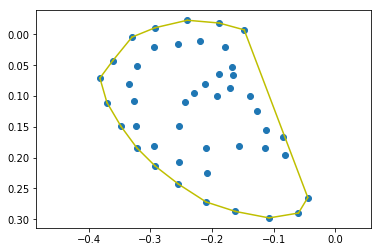

Area of the convex hull is 0.8944716206396275


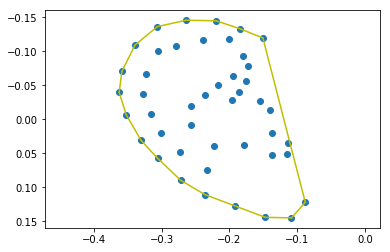

Area of the convex hull is 0.9301253452659186


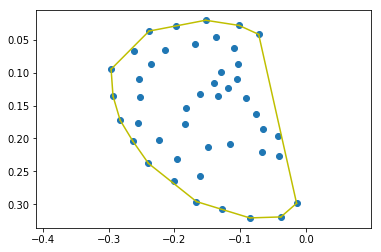

Area of the convex hull is 0.6555182498617608


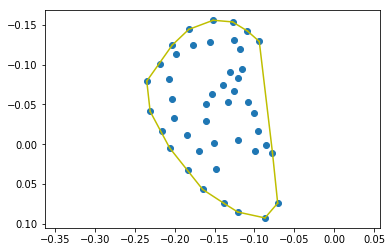

Area of the convex hull is 0.7483005035500685


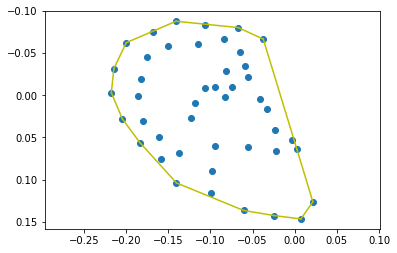

Area of the convex hull is 0.8280253629439174


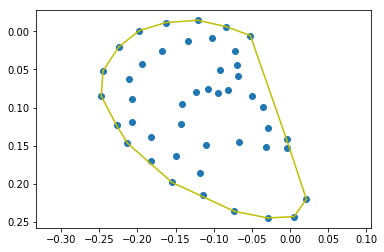

Area of the convex hull is 0.6531449332158976


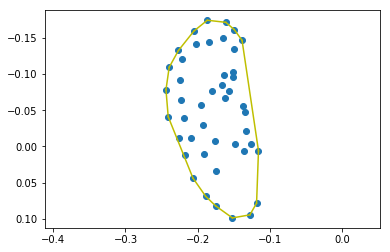

Area of the convex hull is 0.6074281197391357


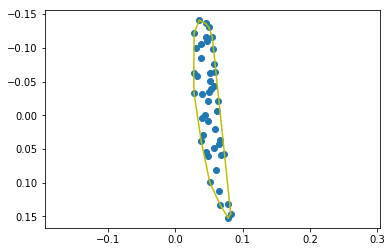

Area of the convex hull is 0.8391566616006253


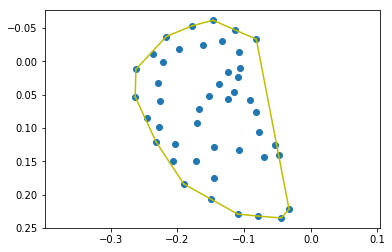

Area of the convex hull is 0.7784420893069576


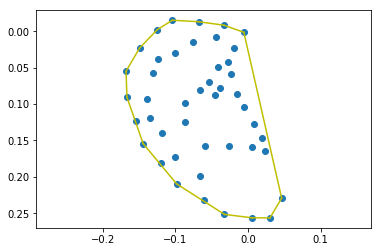

Area of the convex hull is 0.6509729998476587


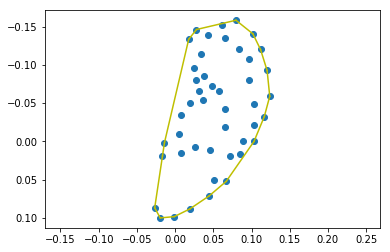

Area of the convex hull is 0.6193430863277787


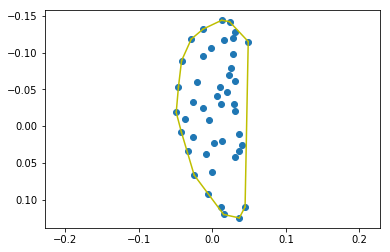

Area of the convex hull is 0.578093225797575


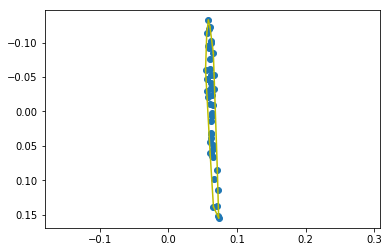

Area of the convex hull is 0.6843874030582882


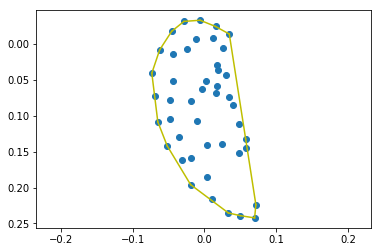

Area of the convex hull is 0.9843544235019906


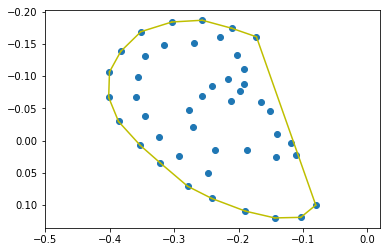

Area of the convex hull is 0.9058535011938107


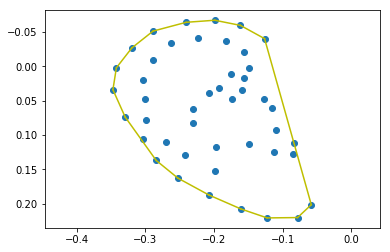

Area of the convex hull is 0.9210927311127286


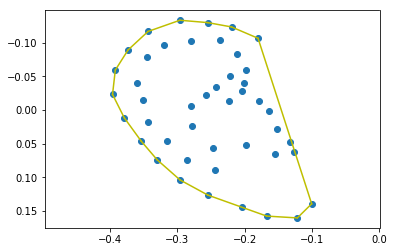

Area of the convex hull is 0.8719488227968945


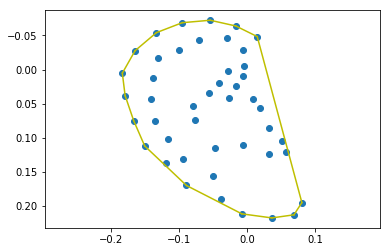

Area of the convex hull is 0.8960351075991136


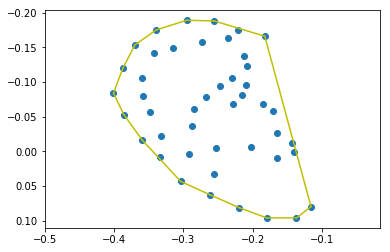

Area of the convex hull is 0.8438292305776509


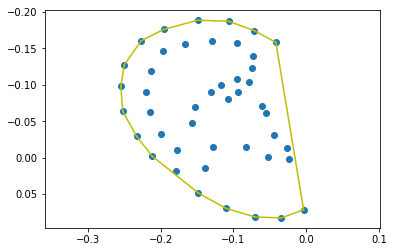

Area of the convex hull is 0.8305314053904151


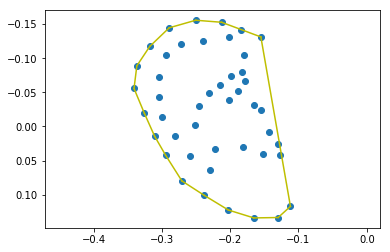

Area of the convex hull is 0.6595621236610074


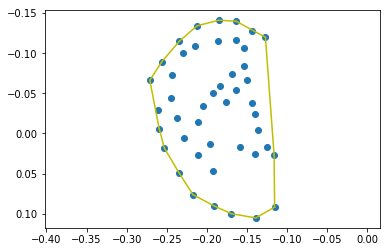

Area of the convex hull is 0.8090085558741024


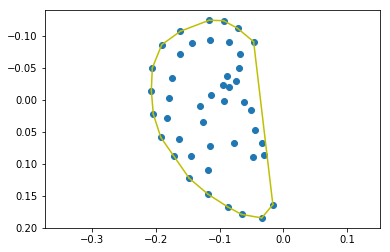

Area of the convex hull is 0.8660168926332258


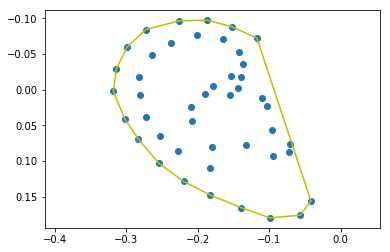

Area of the convex hull is 0.616059200358946


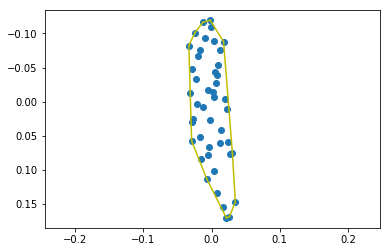

Area of the convex hull is 0.8811027527130441


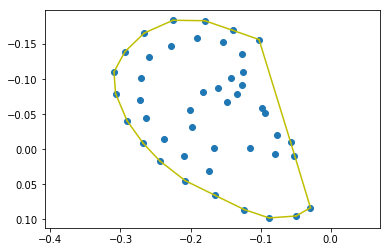

Area of the convex hull is 0.7640957766264772


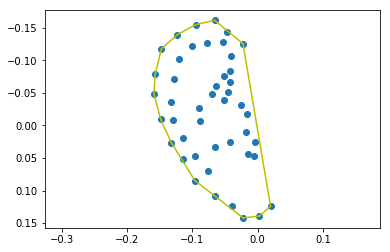

Area of the convex hull is 0.9360482045462359


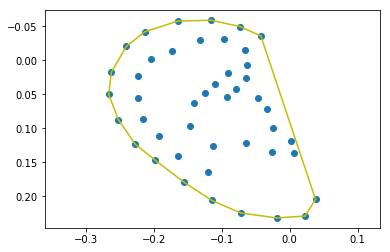

Area of the convex hull is 0.5400373725530047


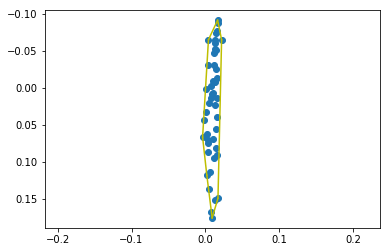

Area of the convex hull is 0.9504664019464095


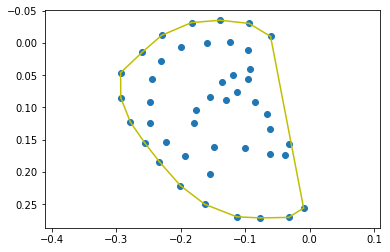

Area of the convex hull is 0.6929218924043782


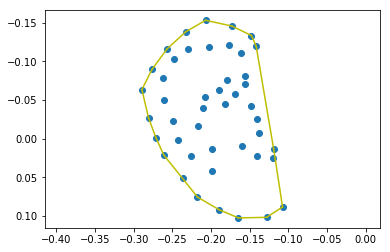

Area of the convex hull is 0.5449998837849991


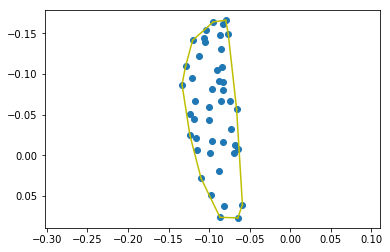

Area of the convex hull is 0.9317689816648268


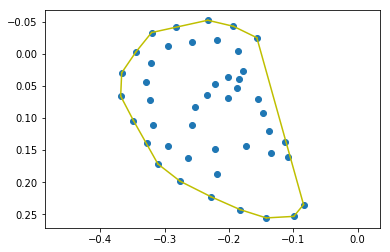

Area of the convex hull is 0.9843544235019906


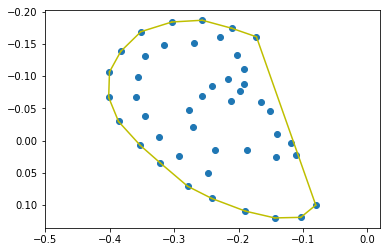

Area of the convex hull is 0.9665526401205674


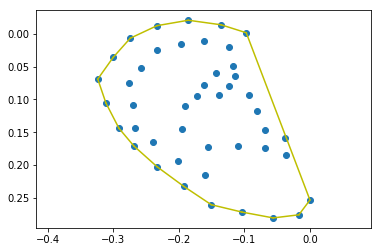

Area of the convex hull is 0.8997078261810914


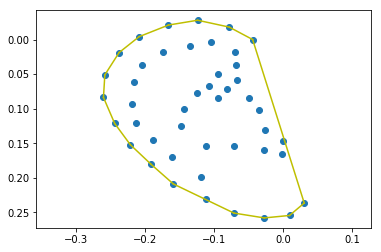

Area of the convex hull is 0.7951722747828872


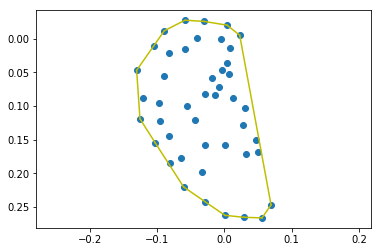

Area of the convex hull is 0.9655318159530495


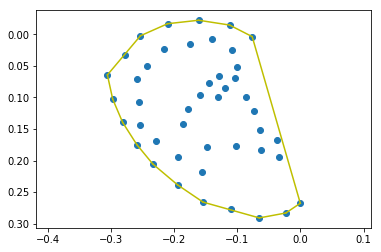

Area of the convex hull is 0.7876045028105814


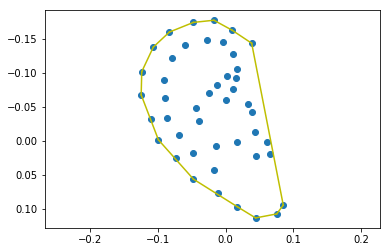

Area of the convex hull is 0.7716124076872988


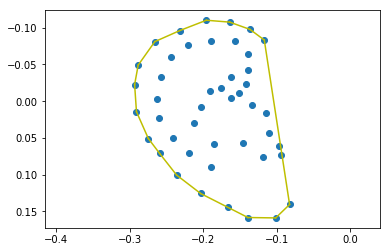

Area of the convex hull is 0.7761469547179913


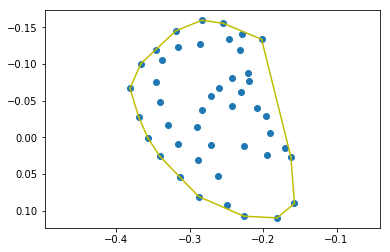

Area of the convex hull is 0.9103327934859426


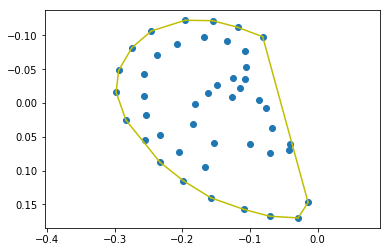

Area of the convex hull is 0.9402139557752445


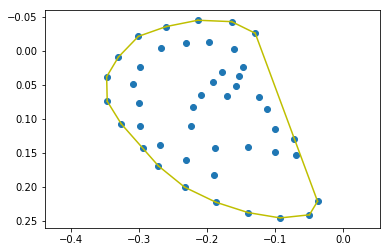

Area of the convex hull is 0.7671559171853982


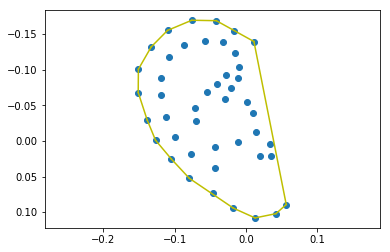

Area of the convex hull is 0.9266462998160896


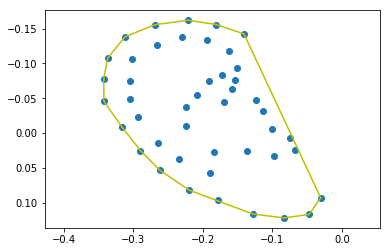

Area of the convex hull is 0.6165751977788629


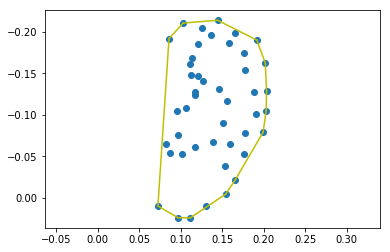

Area of the convex hull is 0.7560820986650219


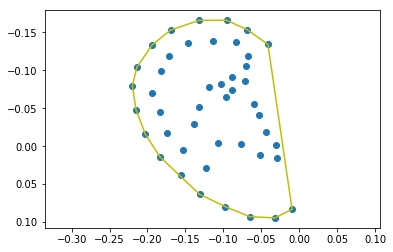

Area of the convex hull is 0.833190895439285


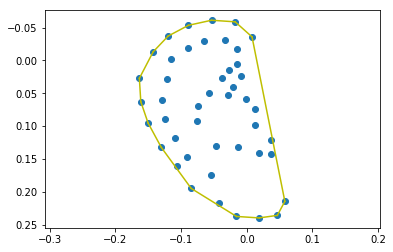

Area of the convex hull is 0.8324682239796946


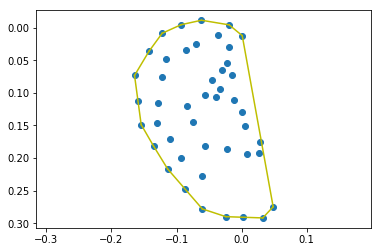

Area of the convex hull is 0.881833486347249


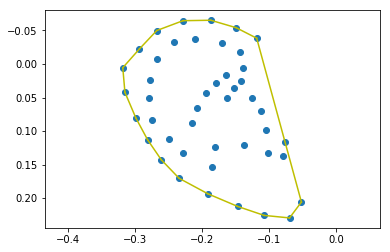

Area of the convex hull is 0.9709035004485636


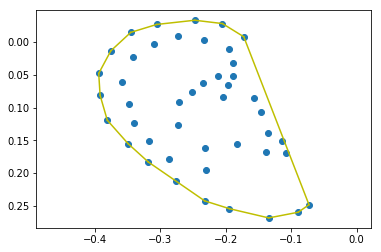

Area of the convex hull is 0.8566861481880497


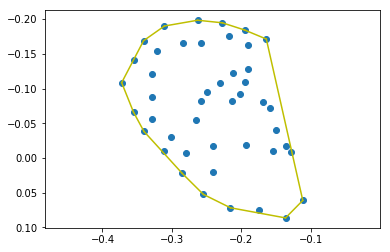

Area of the convex hull is 0.9211980495467351


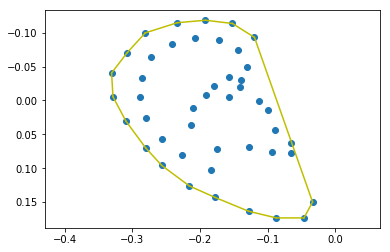

Area of the convex hull is 1.0055327515625705


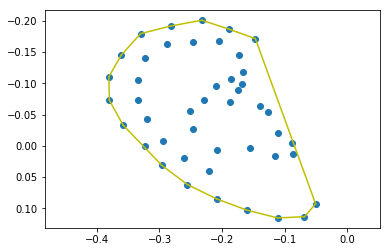

Area of the convex hull is 0.9291192472562311


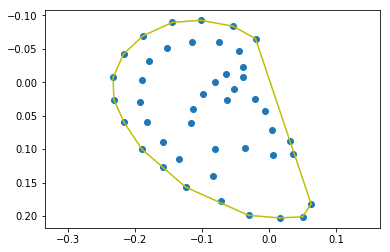

Area of the convex hull is 0.8355992281686884


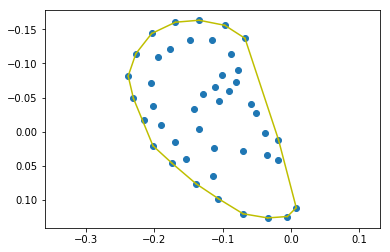

Area of the convex hull is 0.8788111161396861


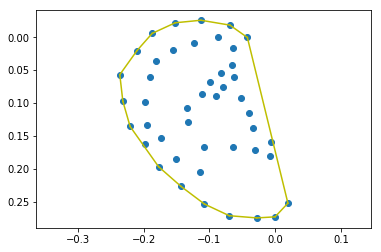

Area of the convex hull is 0.7188856636622911


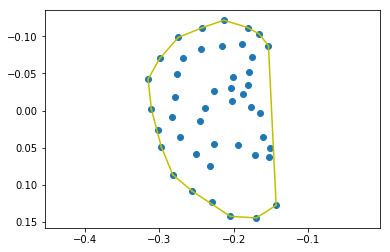

Area of the convex hull is 0.97076966770425


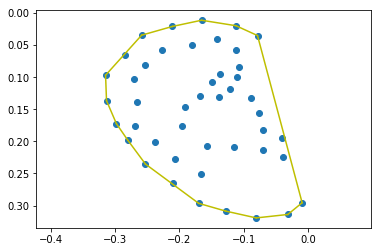

Area of the convex hull is 0.9409943544688356


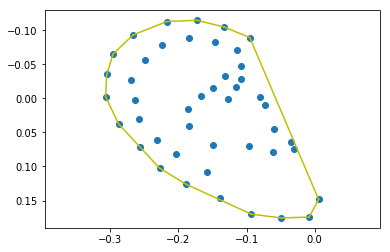

Area of the convex hull is 0.727855098950872


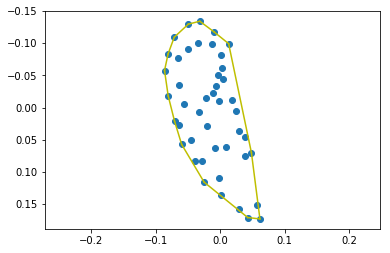

Area of the convex hull is 0.8560988387959702


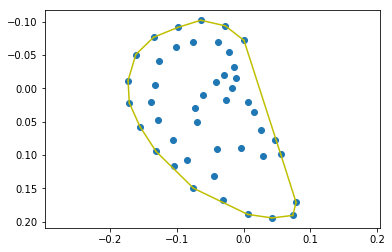

Area of the convex hull is 0.8094034371456249


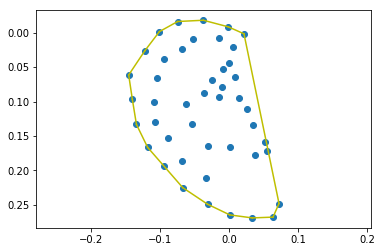

Area of the convex hull is 0.6944819072641008


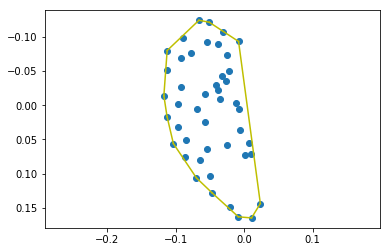

Area of the convex hull is 0.6332576600564546


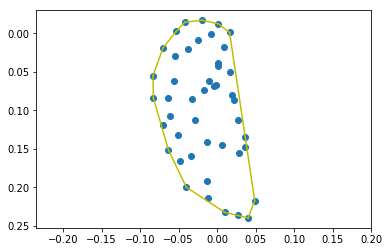

Area of the convex hull is 0.9878773997019363


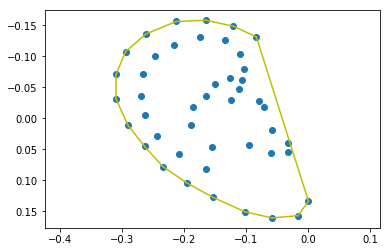

Area of the convex hull is 0.8701290783870385


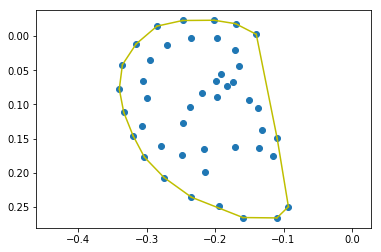

Area of the convex hull is 0.6740347365990859


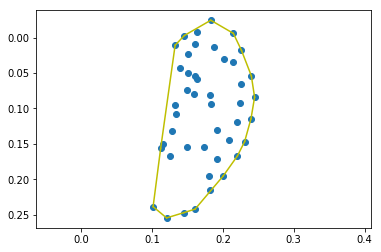

Area of the convex hull is 0.7478241846890644


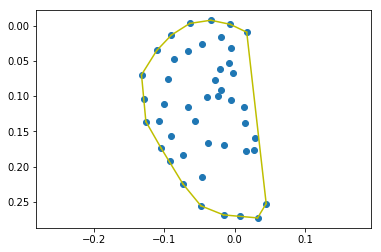

Area of the convex hull is 0.5836363366908031


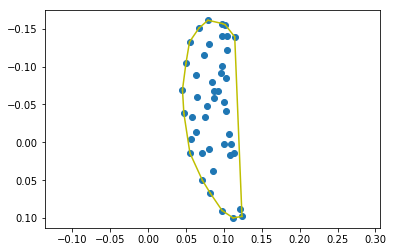

Area of the convex hull is 0.7074874138125649


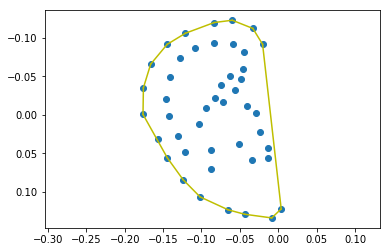

Area of the convex hull is 0.9065441136125576


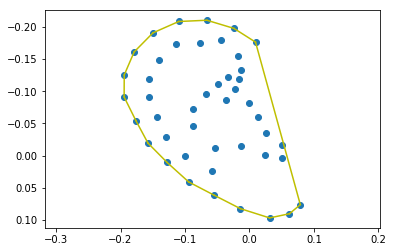

Area of the convex hull is 0.7841568986529187


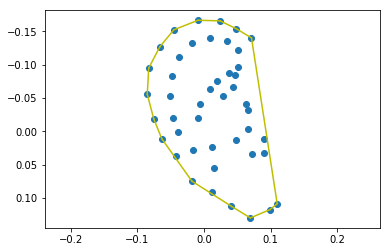

Area of the convex hull is 0.7669552325509283


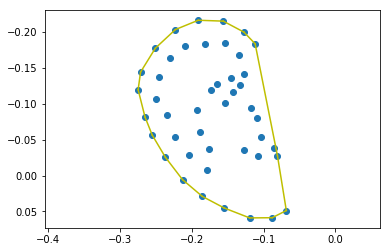

Area of the convex hull is 0.9686164974327326


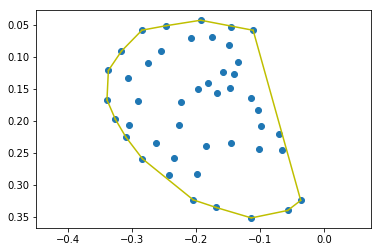

Area of the convex hull is 0.6042199668530148


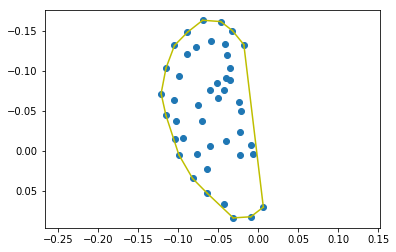

Area of the convex hull is 0.7007537561289187


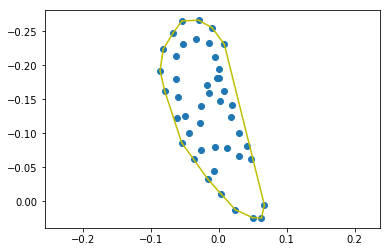

Area of the convex hull is 0.9993639981266179


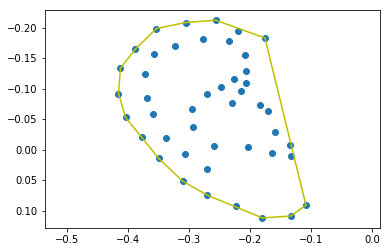

Area of the convex hull is 0.8576399215831161


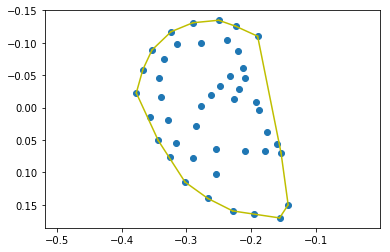

Area of the convex hull is 0.9714799906747456


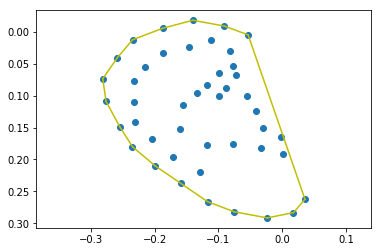

Area of the convex hull is 0.6789874284277794


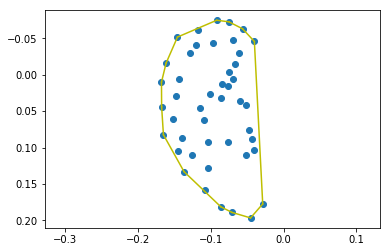

Area of the convex hull is 0.9747811494123704


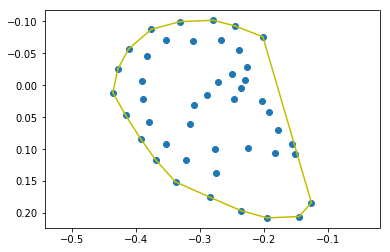

Area of the convex hull is 0.9532273041567167


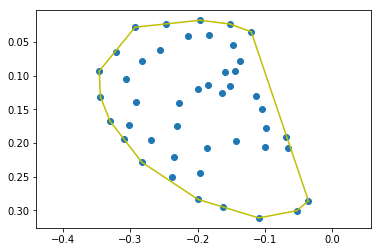

Area of the convex hull is 0.7567862809891184


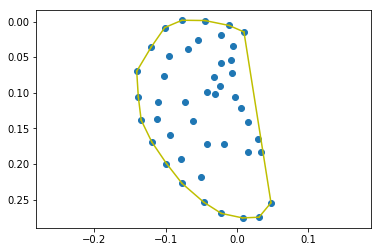

Area of the convex hull is 0.9552244254139715


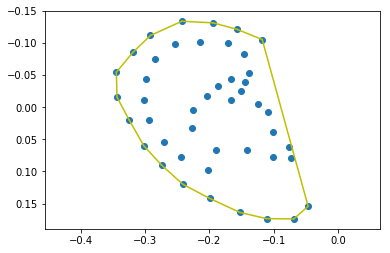

Area of the convex hull is 0.9337729310756963


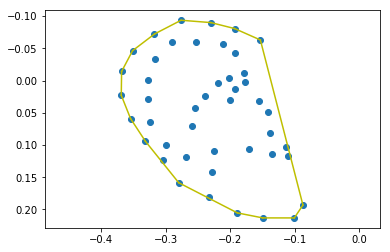

Area of the convex hull is 0.9026855244420882


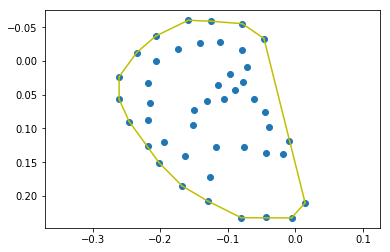

Area of the convex hull is 0.7949785555545981


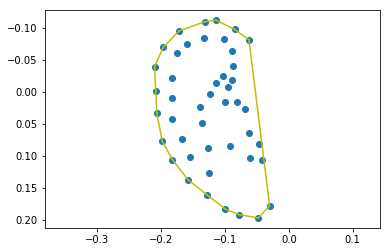

Area of the convex hull is 0.9050856988384219


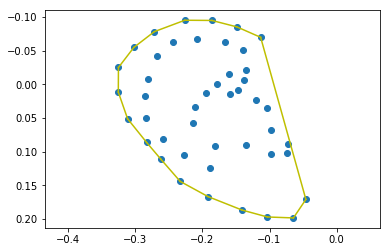

Area of the convex hull is 0.7357191199084988


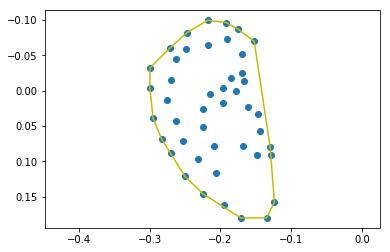

Area of the convex hull is 0.7467737580108857


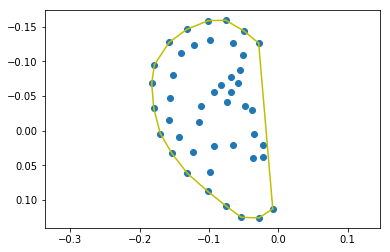

Area of the convex hull is 0.8693826137939804


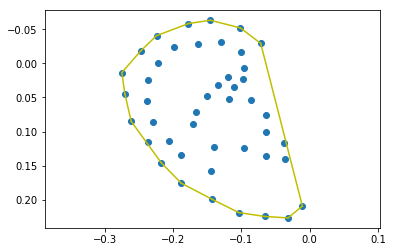

Area of the convex hull is 0.5340862034446148


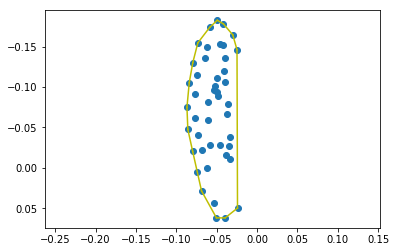

Area of the convex hull is 0.6786938053628598


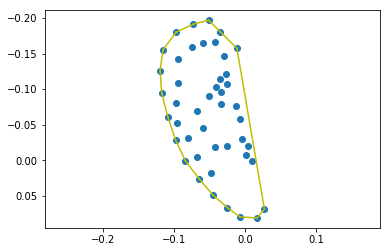

Area of the convex hull is 0.9116180967882672


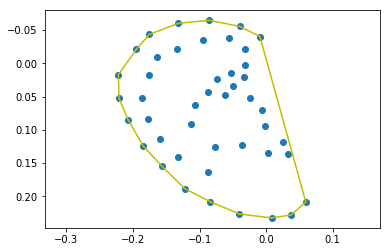

Area of the convex hull is 0.9191425716467174


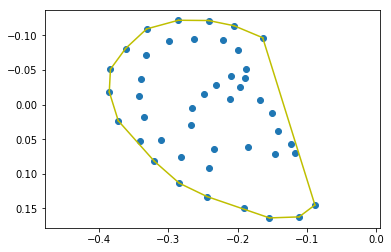

Area of the convex hull is 0.8654507384357676


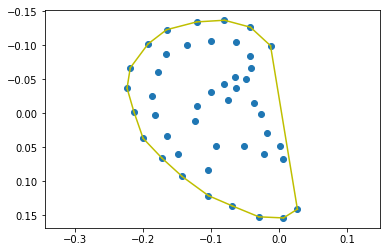

Area of the convex hull is 0.6614168296218674


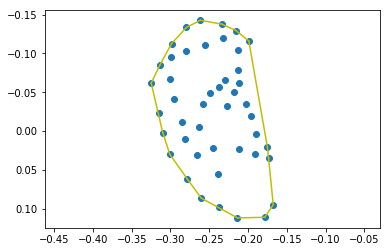

Area of the convex hull is 0.7400505789009187


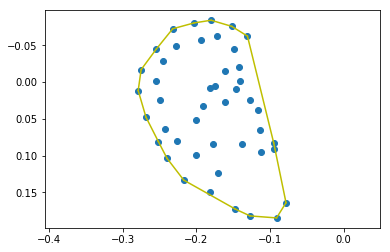

Area of the convex hull is 0.7316812645642705


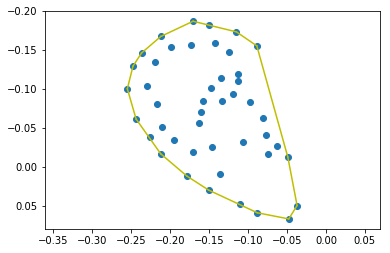

Area of the convex hull is 0.6653880605953748


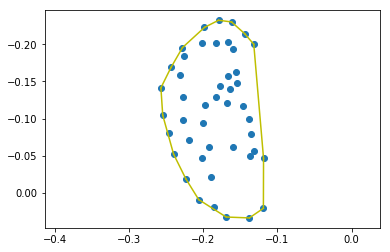

Area of the convex hull is 0.9655318159530495


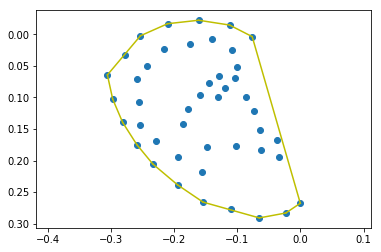

Area of the convex hull is 0.6784763814286443


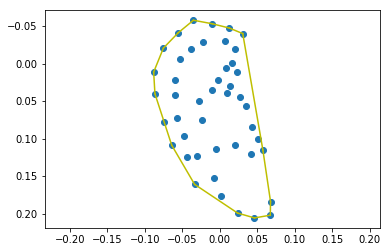

Area of the convex hull is 0.7601093755611397


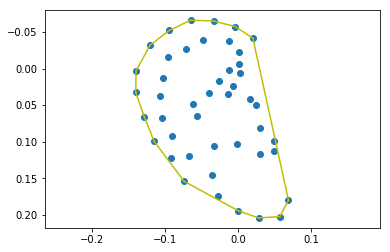

Area of the convex hull is 0.8456882971436896


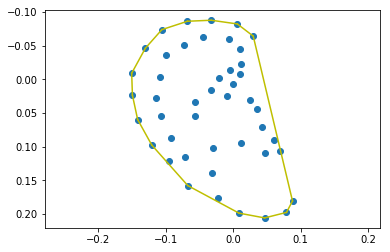

Area of the convex hull is 0.7508365603256726


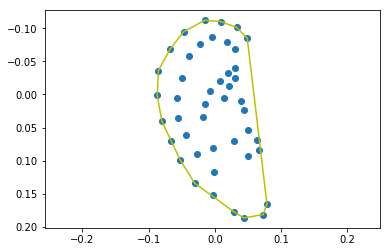

Area of the convex hull is 0.9504664019464095


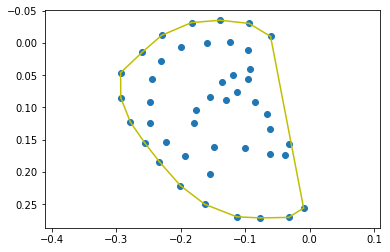

Area of the convex hull is 0.9453260866222575


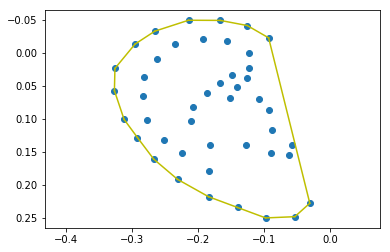

Area of the convex hull is 0.8276098782893054


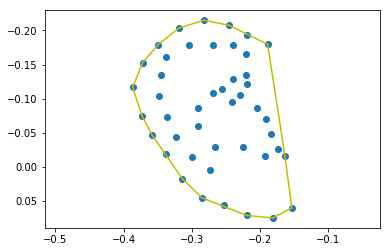

Area of the convex hull is 0.6502282352402357


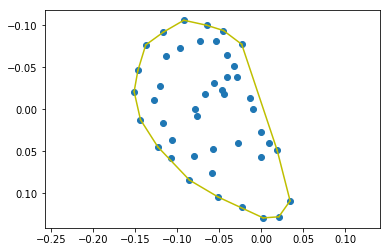

Area of the convex hull is 0.9076826310366355


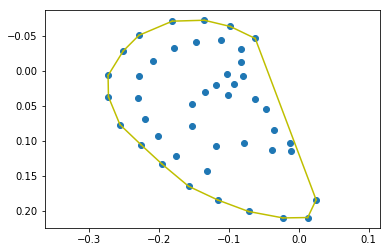

Area of the convex hull is 0.7469855976087728


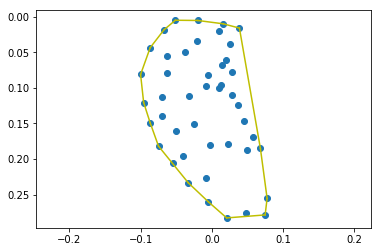

Area of the convex hull is 0.9523548964561142


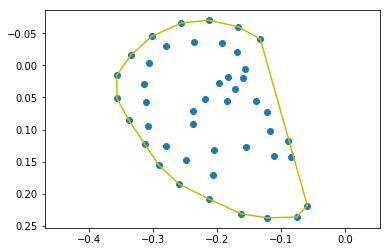

Area of the convex hull is 0.8611300362294085


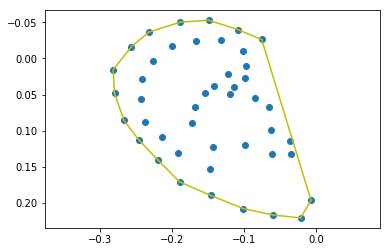

Area of the convex hull is 1.0285504266655277


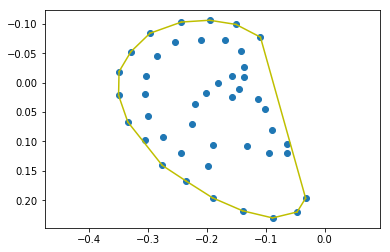

Area of the convex hull is 0.8791209039557502


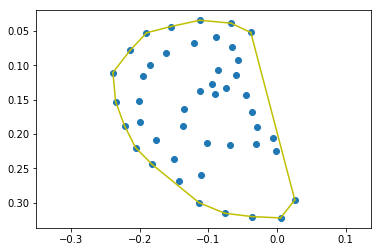

Area of the convex hull is 0.924278005734186


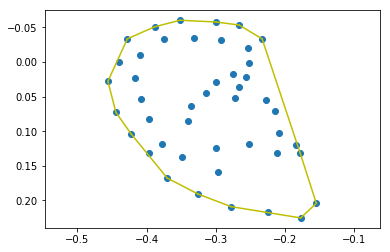

Area of the convex hull is 0.6628799805951969


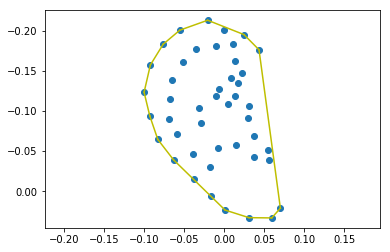

Area of the convex hull is 0.9477068996461602


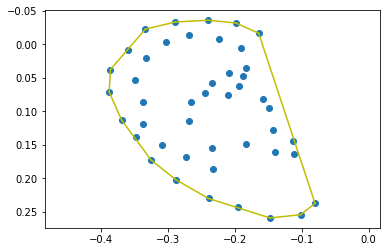

Area of the convex hull is 0.8806368166396588


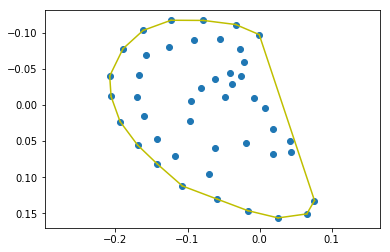

Area of the convex hull is 0.7708426443609616


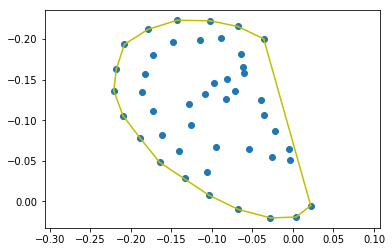

Area of the convex hull is 0.8113880326042388


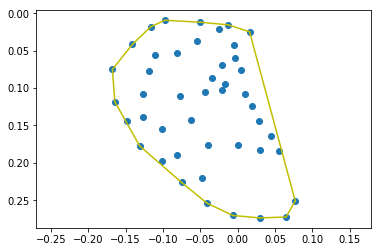

Area of the convex hull is 0.8355631106579847


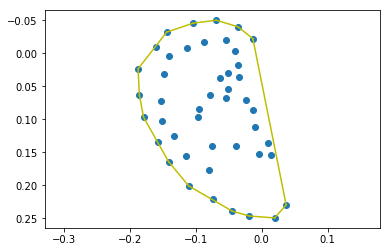

Area of the convex hull is 0.9674308688312797


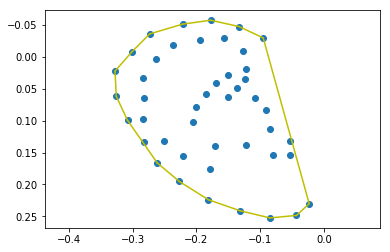

Area of the convex hull is 0.7273828341440657


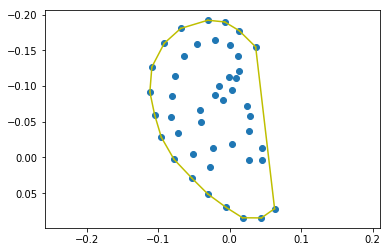

Area of the convex hull is 0.9214967189569613


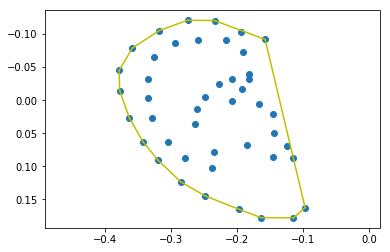

Area of the convex hull is 0.870787729876218


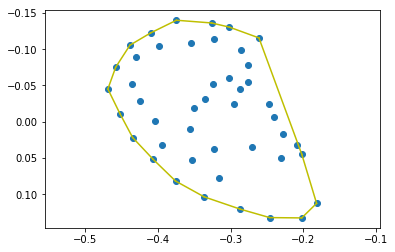

Area of the convex hull is 0.8664790244848427


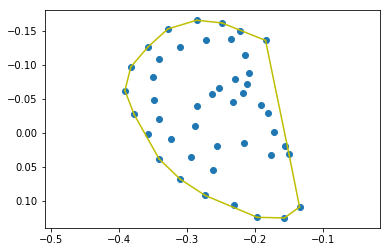

Area of the convex hull is 0.5613704350955795


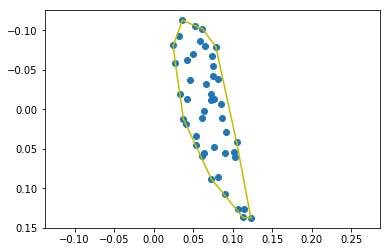

Area of the convex hull is 0.8337698386655045


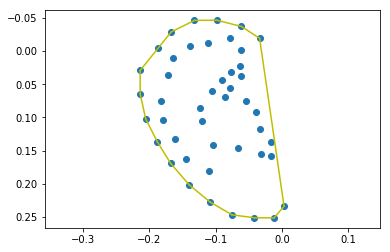

Area of the convex hull is 0.6396468892421433


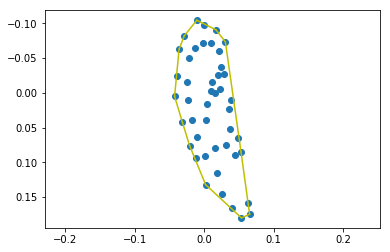

Area of the convex hull is 0.775916914341597


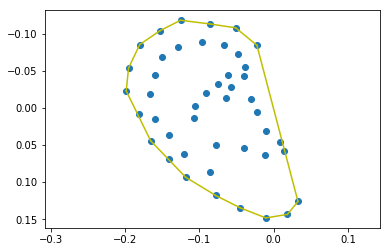

Area of the convex hull is 0.8839666456453469


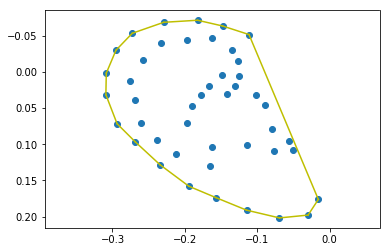

Area of the convex hull is 0.784396795248561


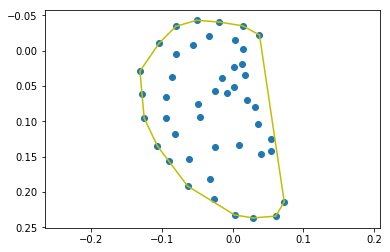

Area of the convex hull is 0.6236183388298157


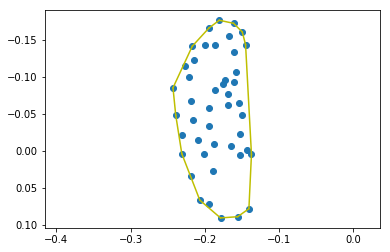

Area of the convex hull is 0.7803966059944554


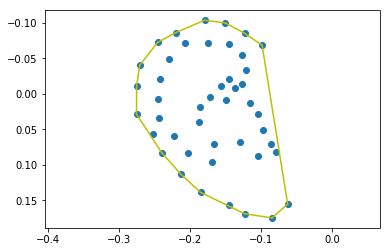

Area of the convex hull is 0.959026421009866


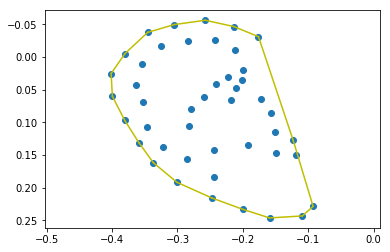

Area of the convex hull is 0.8108753476296253


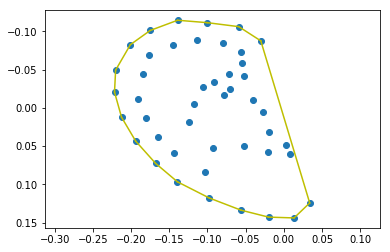

Area of the convex hull is 0.7225246301369116


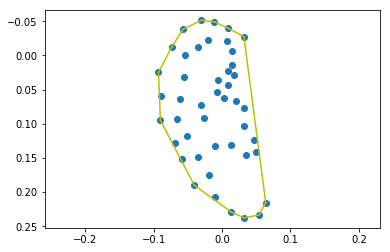

Area of the convex hull is 0.5913372959393097


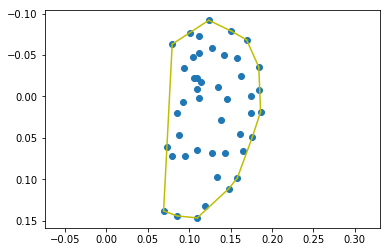

Area of the convex hull is 0.9076826310366355


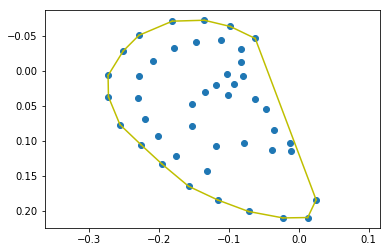

Area of the convex hull is 0.5386674663082505


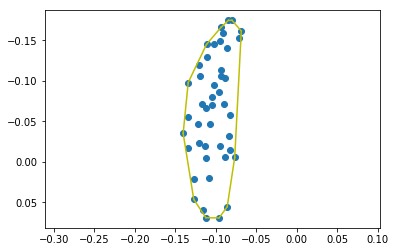

Area of the convex hull is 0.6502835388977922


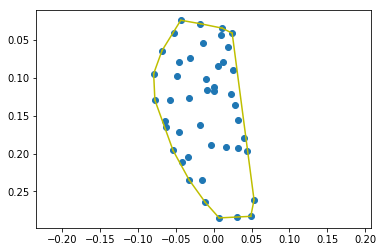

Area of the convex hull is 0.9320531190744425


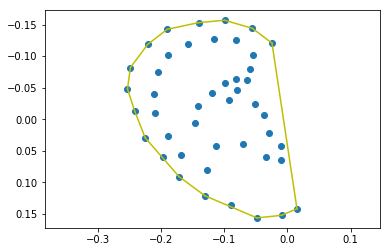

Area of the convex hull is 0.5831914869741369


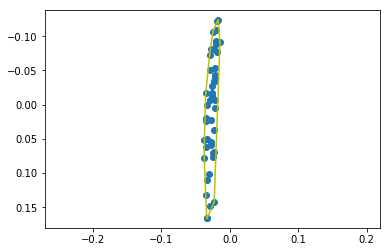

Area of the convex hull is 0.8243965604072104


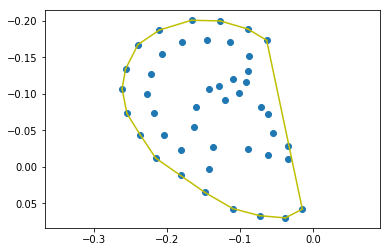

Area of the convex hull is 0.7787104152381725


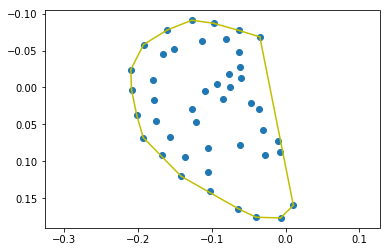

Area of the convex hull is 0.8542193866389439


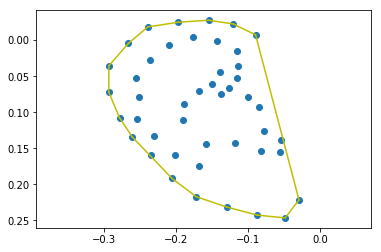

Area of the convex hull is 0.8498420573243695


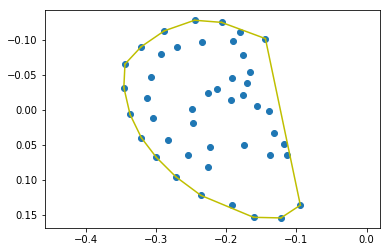

Area of the convex hull is 0.7107067769101758


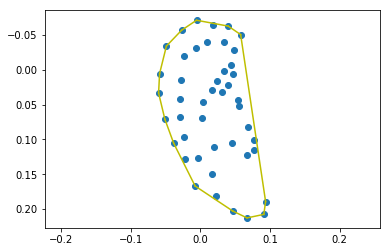

Area of the convex hull is 0.650348564381047


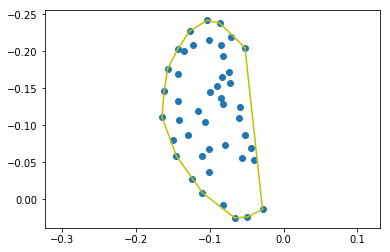

Area of the convex hull is 0.8113688668139548


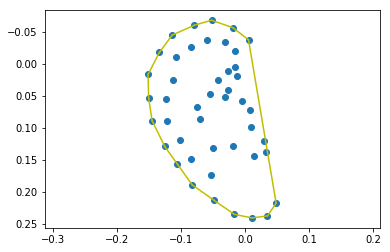

Area of the convex hull is 0.8213517065670706


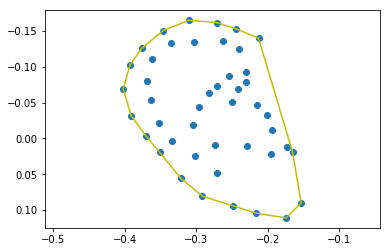

Area of the convex hull is 0.8293514618782508


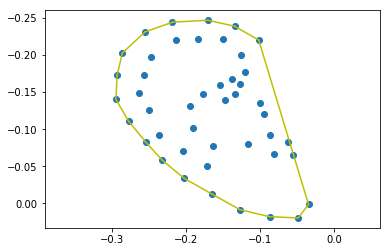

Area of the convex hull is 0.7025011647122177


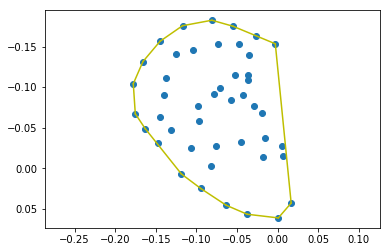

Area of the convex hull is 0.9778175990215388


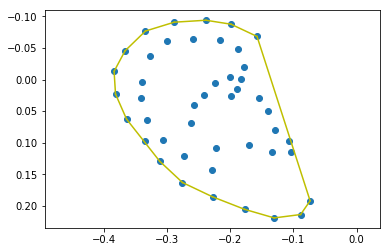

Area of the convex hull is 0.9182755770450663


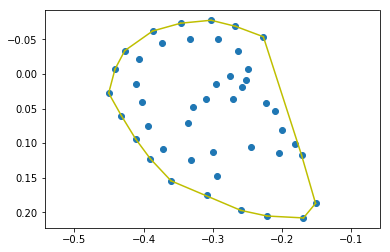

Area of the convex hull is 0.8740363124818149


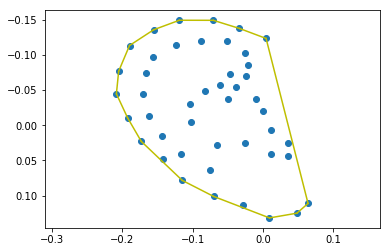

Area of the convex hull is 0.7416865385713284


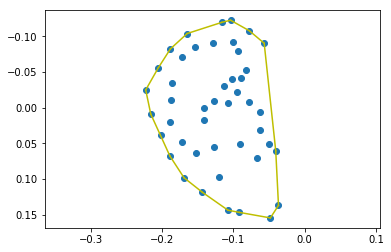

Area of the convex hull is 0.9509072263837298


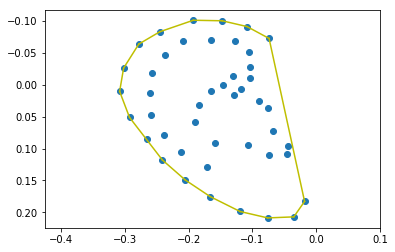

Area of the convex hull is 0.9636510474102533


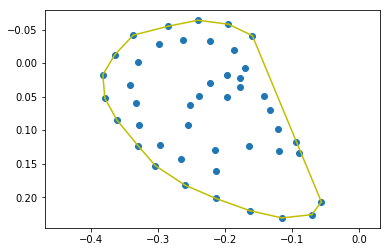

Area of the convex hull is 0.8791048135134742


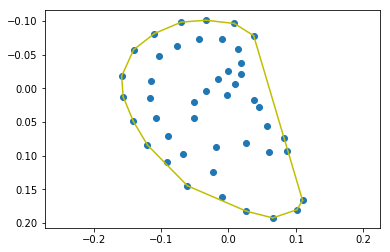

Area of the convex hull is 0.8216985364352936


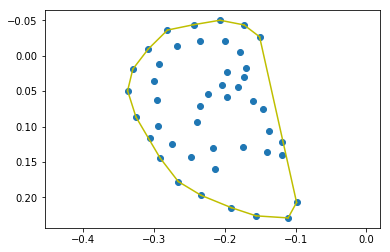

Area of the convex hull is 0.5482290664914387


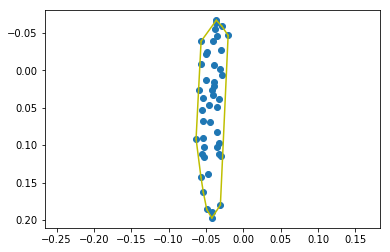

Area of the convex hull is 0.6751052209644206


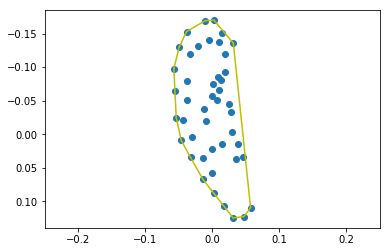

Area of the convex hull is 0.969765333809321


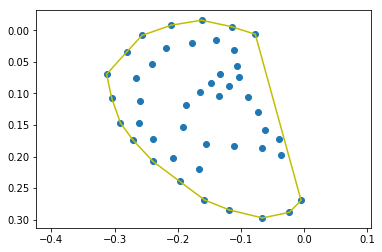

Area of the convex hull is 0.5237052593070031


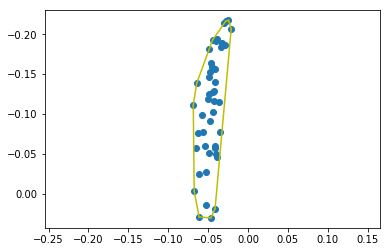

Area of the convex hull is 0.7613947596805882


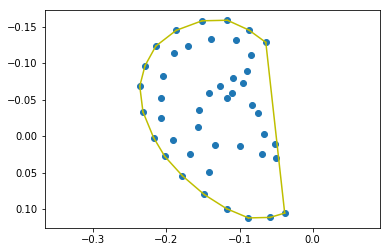

Area of the convex hull is 0.5643363319853502


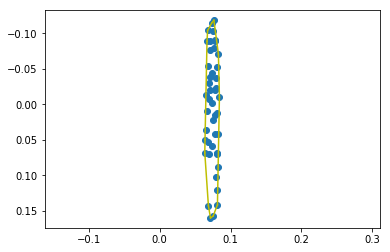

Area of the convex hull is 0.9482910216322284


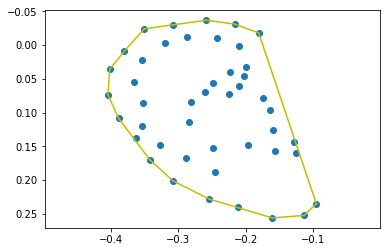

Area of the convex hull is 0.7662404063173502


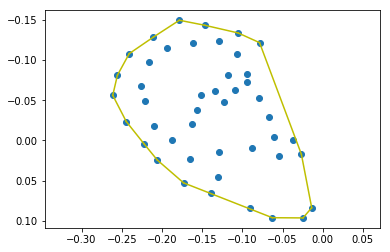

Area of the convex hull is 0.9152870785076518


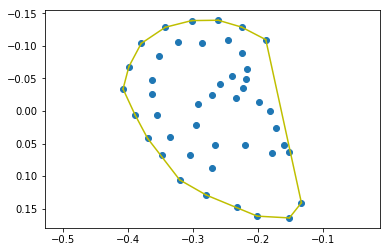

Area of the convex hull is 0.8370923481197577


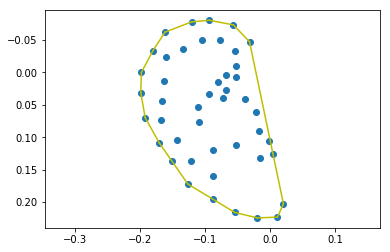

Area of the convex hull is 0.5953985594223691


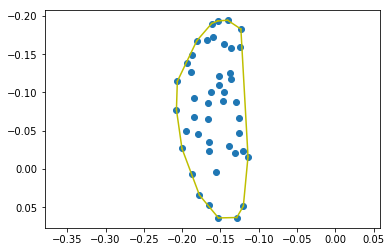

Area of the convex hull is 0.9057040655271467


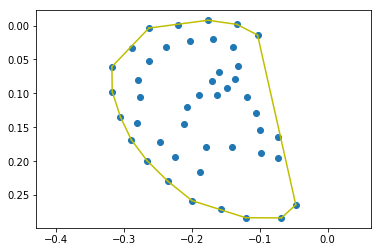

Area of the convex hull is 0.8001423781460835


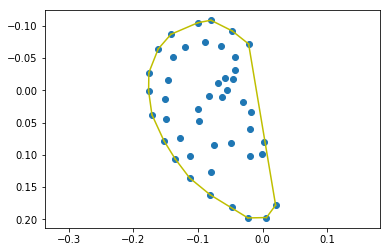

Area of the convex hull is 0.859927909197968


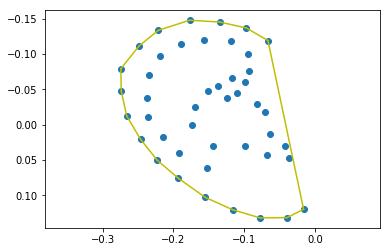

Area of the convex hull is 0.6340563802760588


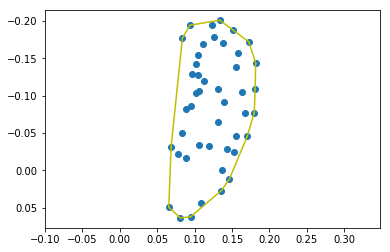

Area of the convex hull is 0.8773085136206189


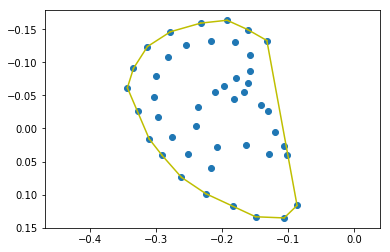

Area of the convex hull is 0.7140237314282086


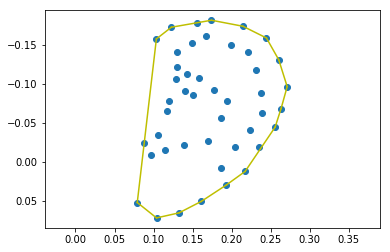

Area of the convex hull is 0.6453658009053954


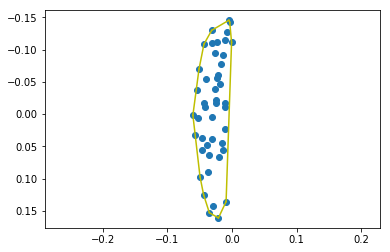

Area of the convex hull is 0.9315034445840205


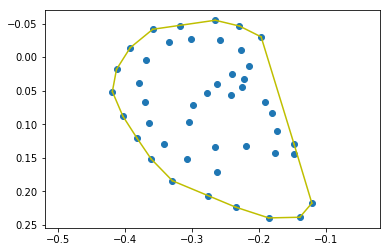

Area of the convex hull is 0.8217611668860182


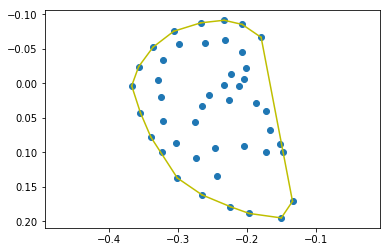

Area of the convex hull is 0.7698198865420243


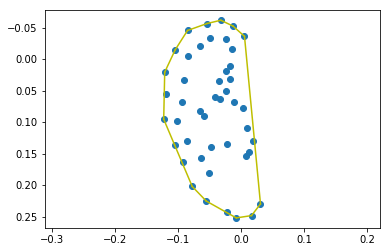

Area of the convex hull is 0.739497898200068


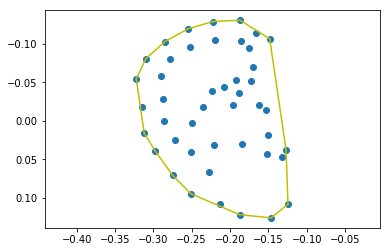

Area of the convex hull is 0.9764157425480687


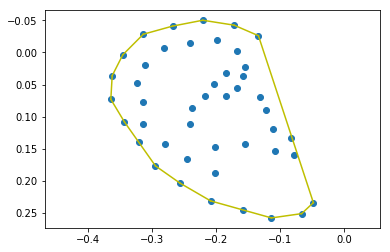

Area of the convex hull is 0.8543392552839687


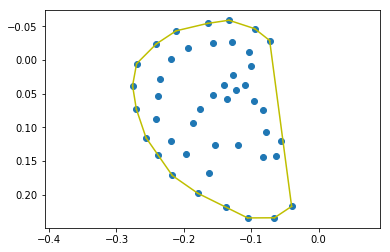

Area of the convex hull is 0.5757585385642577


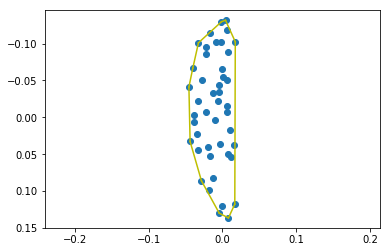

Area of the convex hull is 0.7069114486581044


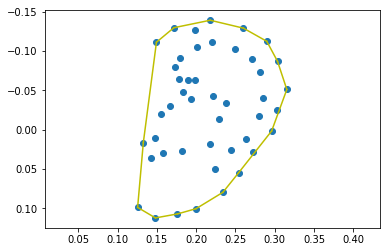

Area of the convex hull is 0.9336847023967548


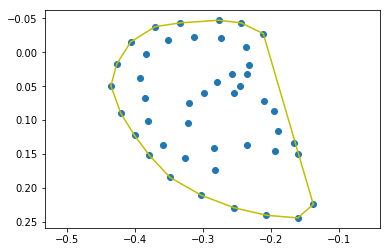

Area of the convex hull is 0.7783480018786966


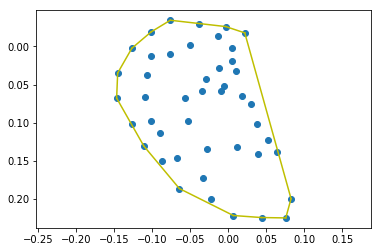

Area of the convex hull is 0.8654455366752865


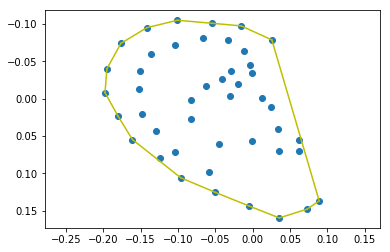

Area of the convex hull is 0.6126725594451055


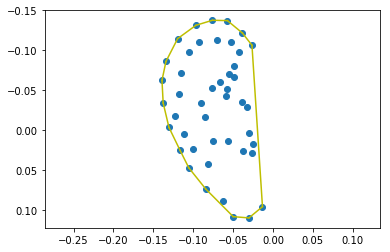

Area of the convex hull is 0.8415230273643026


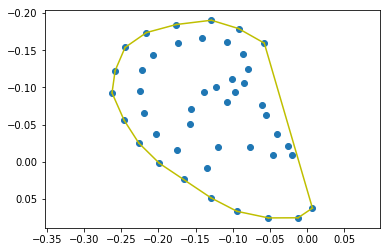

Area of the convex hull is 0.5876492380532304


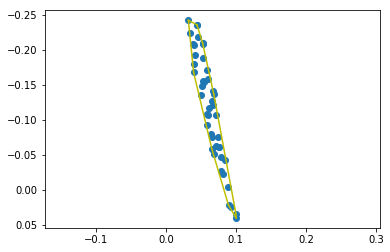

Area of the convex hull is 0.9002622604924225


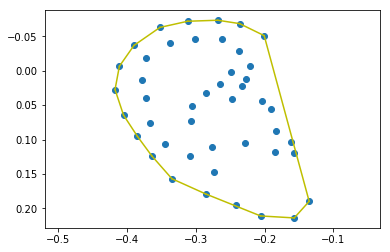

Area of the convex hull is 0.8836120854146339


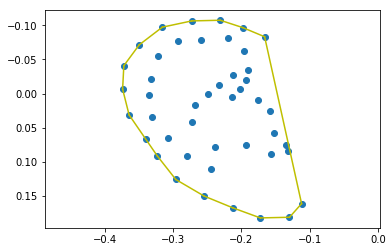

In [25]:
y_pred = net.predict(X)

test_ears = y_pred.reshape((-1, 45, 2))
areas = []


for ear in test_ears:
    hull = ConvexHull(ear)
    areas.append(hull.area)
    print('Area of the convex hull is {}'.format(hull.area))
    ax=plt.gca()
    ax.plot(ear[:,0], ear[:,1], 'o')
    for simplex in hull.simplices:
        ax.plot(ear[simplex, 0], ear[simplex, 1], 'y-')
        #plt.plot(ear[hull.vertices, 0], ear[hull.vertices, 1], 'm--', lw=2)
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.axes().set_aspect('equal', 'datalim')
    plt.show()


In [14]:
my_areas = np.array(areas)
print(my_areas.min())
print(my_areas.max())
print(my_areas.mean(), my_areas.std())
my_areas[ my_areas < 0.55]

0.523705259307
1.02855042667
0.806027332077 0.126531738314


array([ 0.54247288,  0.54003737,  0.54499988,  0.5340862 ,  0.53866747,
        0.54822907,  0.52370526])

In [53]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.sparse import coo_matrix, csgraph

def ordered_hull_idx_2d(hull):
    n = hull.simplices.shape[0]
    
    # determine order of edges in the convex hull
    v = coo_matrix((np.ones(2*n), (np.repeat(np.arange(n), 2), hull.neighbors.ravel())))
    facet_order = csgraph.depth_first_order(v, 0, return_predecessors=False)
    facet_vidx = hull.simplices[facet_order]
    
    # pick one vertex for each edge, based on which direction the walk went
    m = hull.neighbors[facet_order][:-1] == facet_order[1:,None]
    i = np.arange(n)
    j = np.r_[np.where(m)[1], 0] 
    
    ordered_vertex_idx = facet_vidx[i, j]
    
    # sanity check
    assert np.all(np.unique(ordered_vertex_idx) == np.unique(hull.simplices.ravel()))

    return ordered_vertex_idx

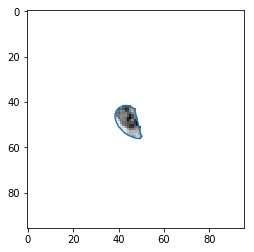

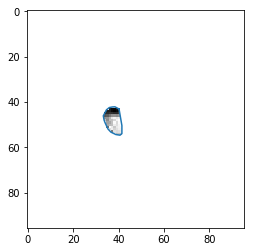

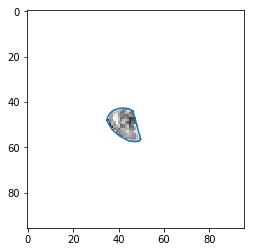

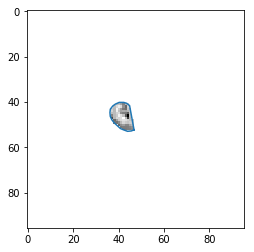

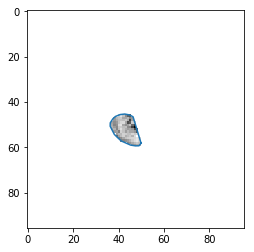

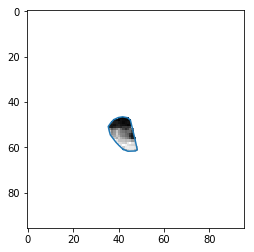

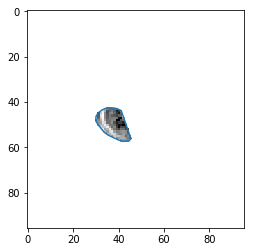

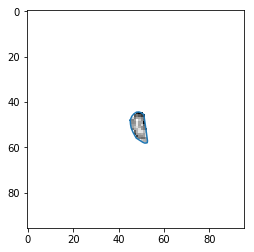

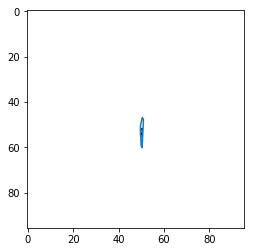

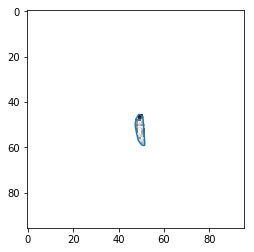

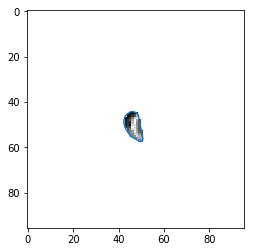

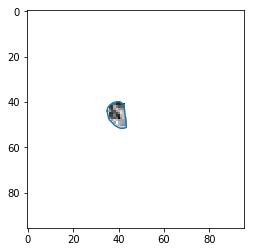

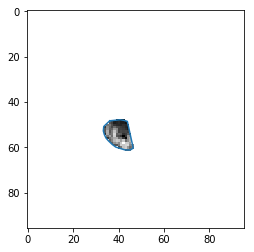

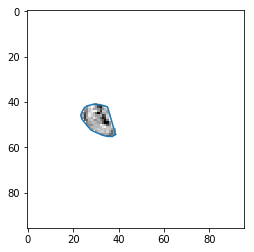

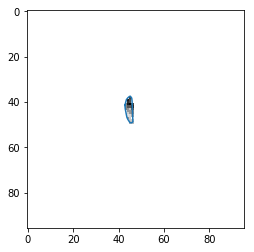

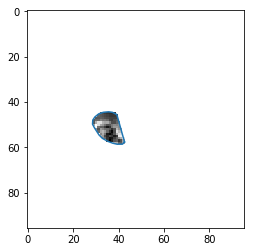

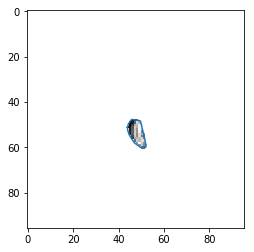

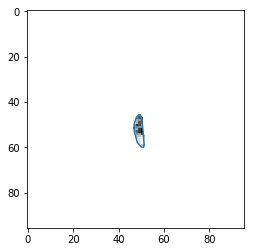

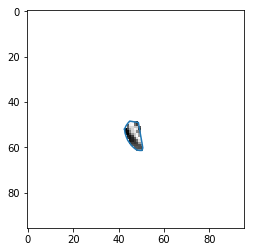

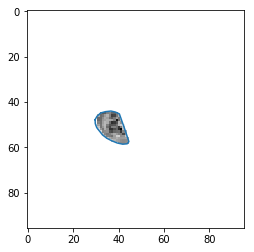

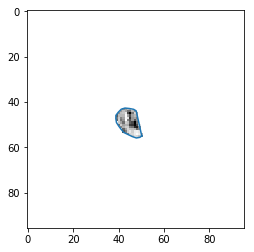

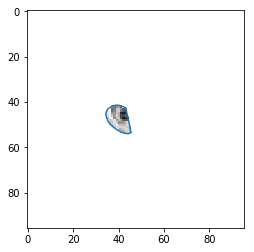

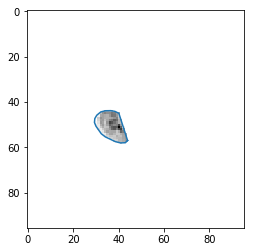

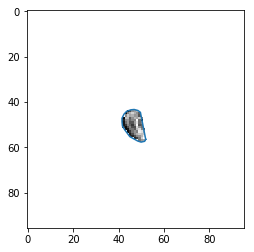

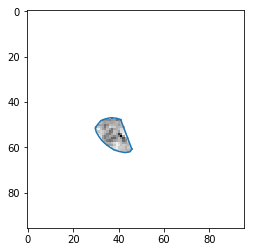

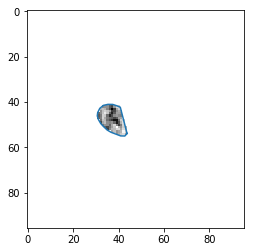

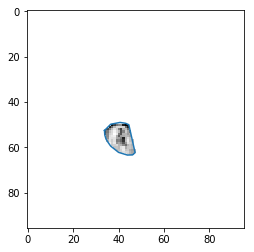

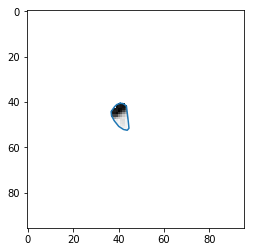

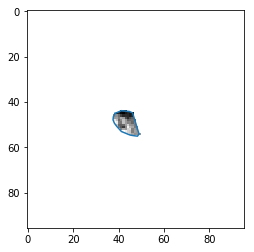

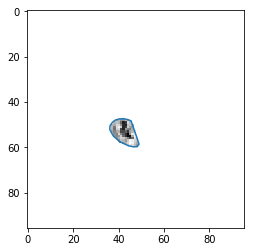

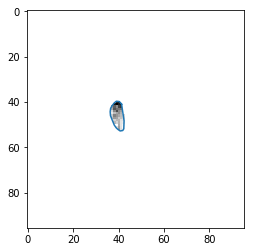

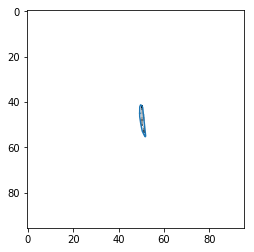

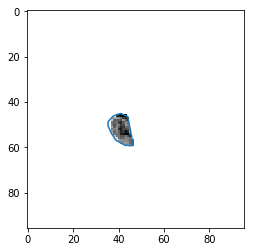

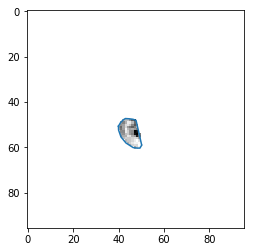

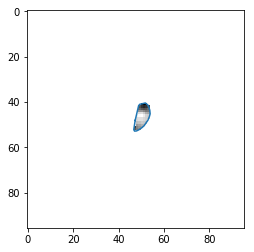

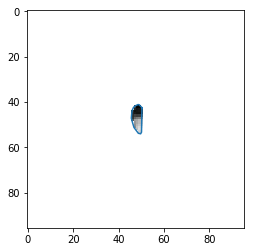

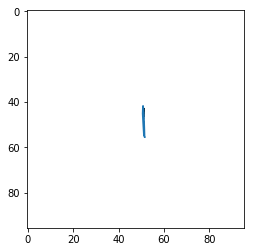

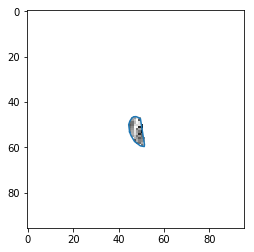

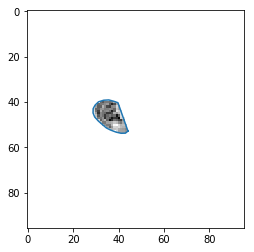

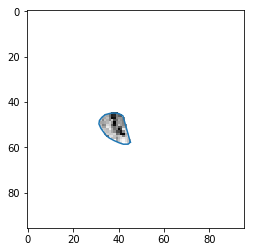

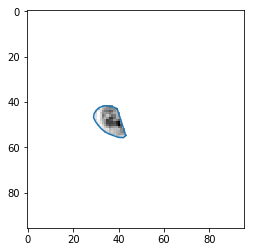

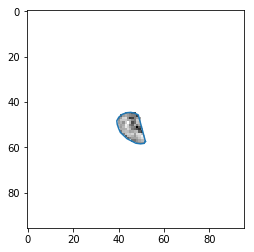

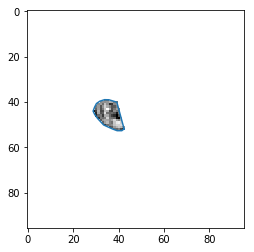

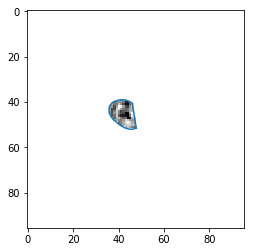

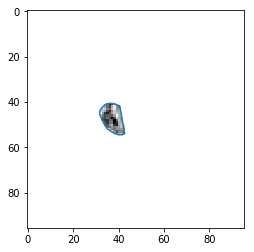

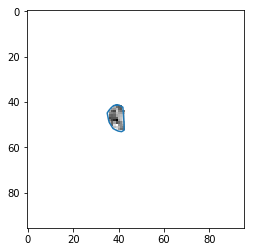

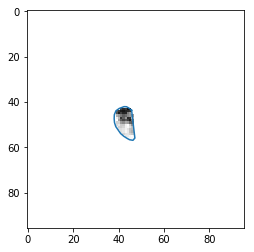

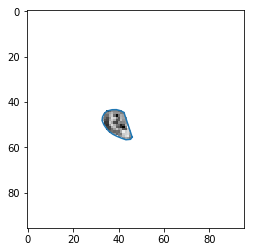

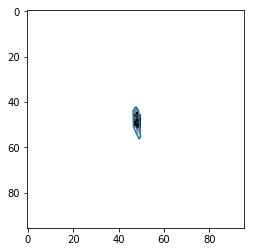

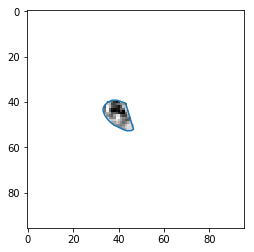

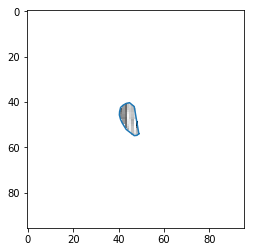

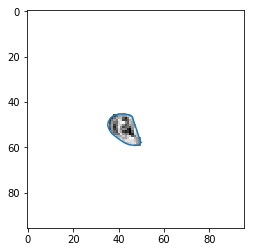

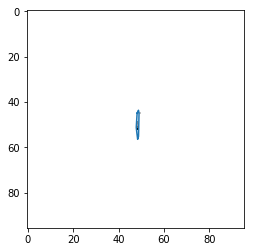

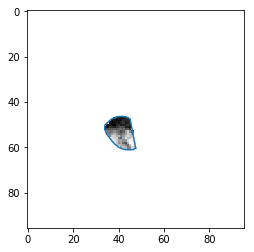

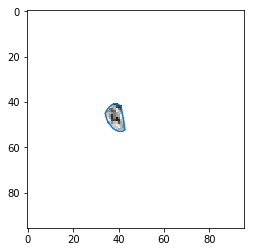

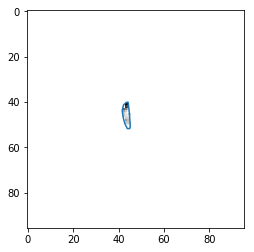

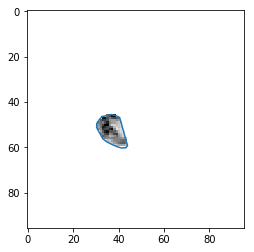

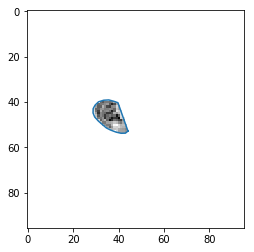

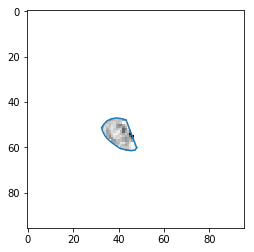

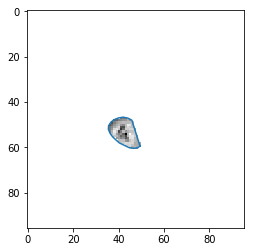

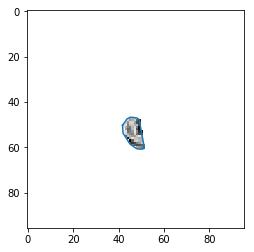

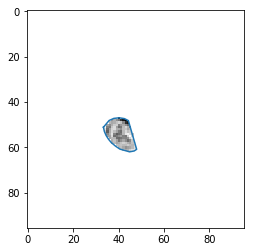

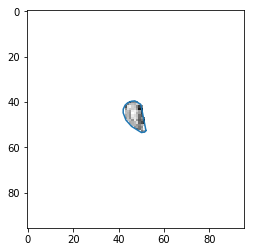

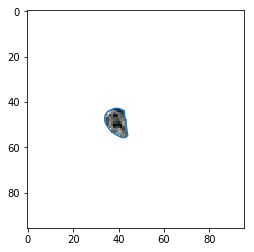

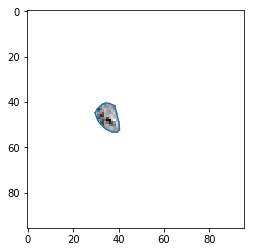

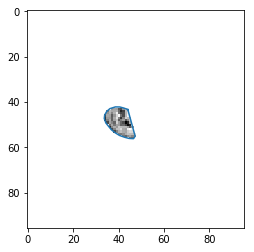

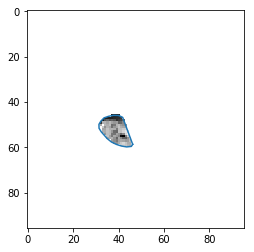

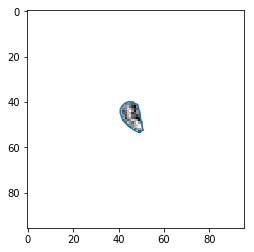

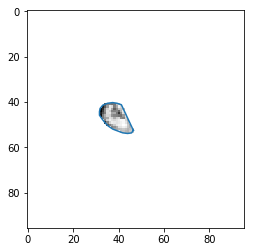

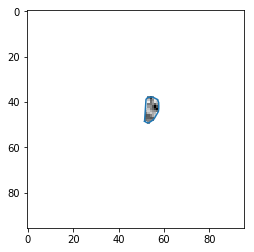

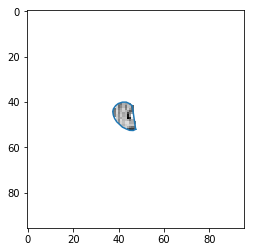

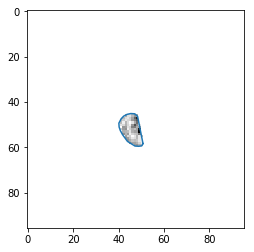

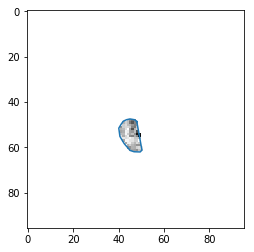

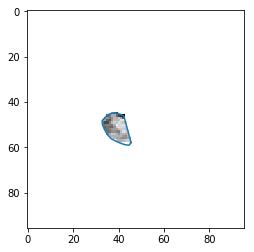

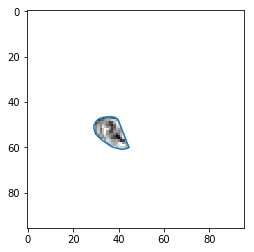

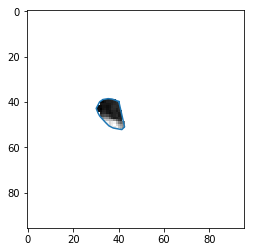

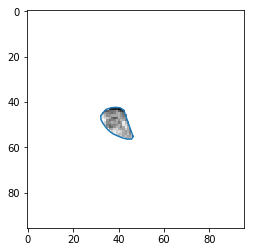

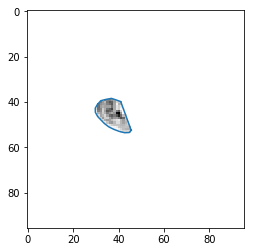

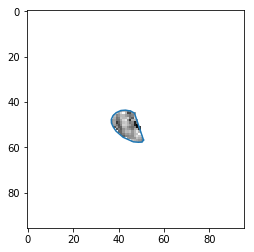

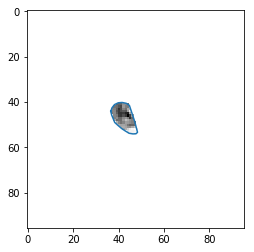

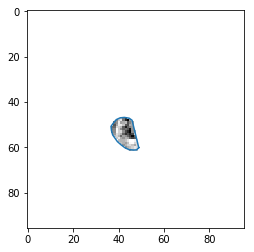

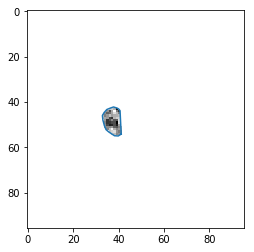

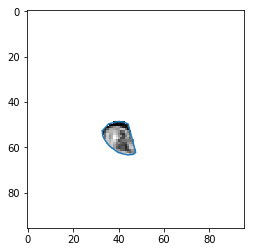

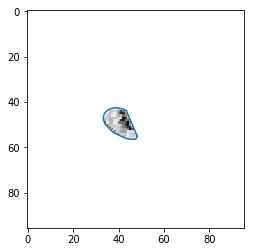

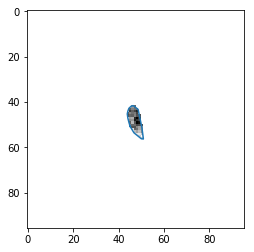

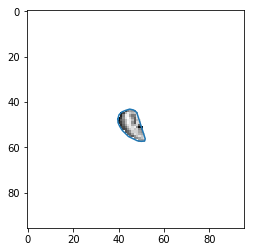

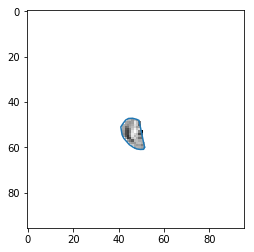

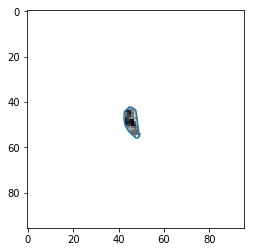

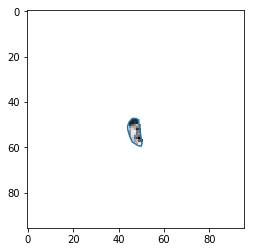

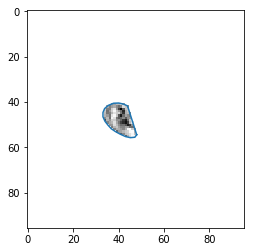

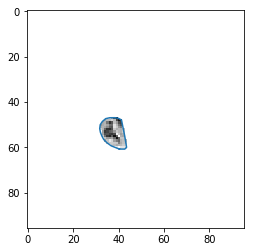

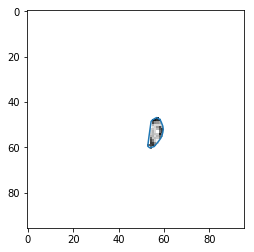

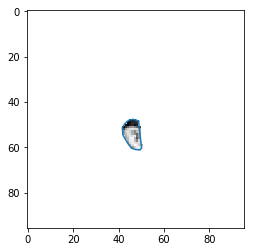

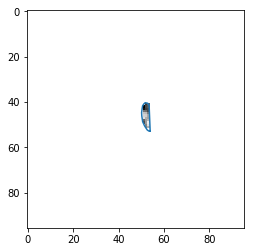

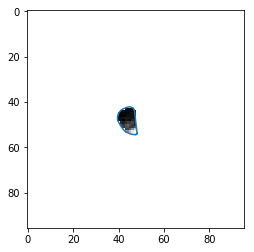

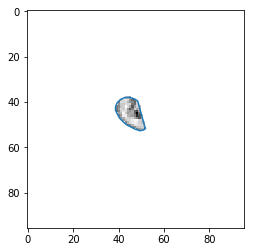

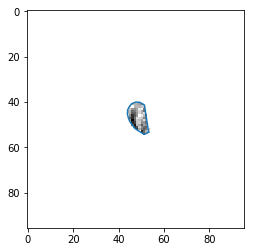

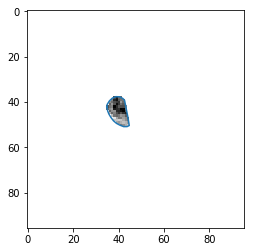

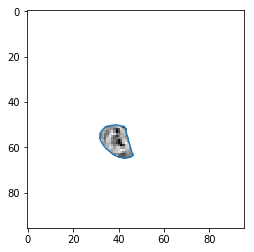

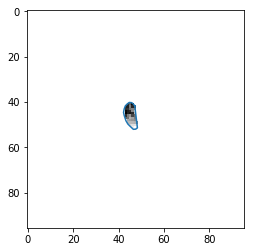

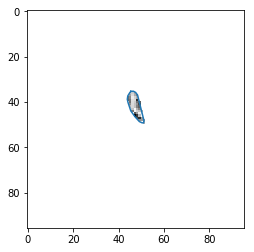

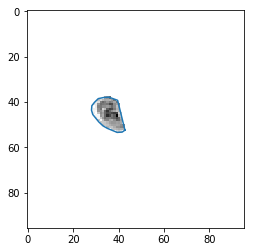

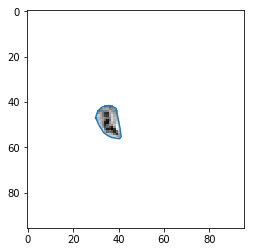

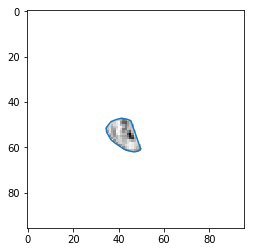

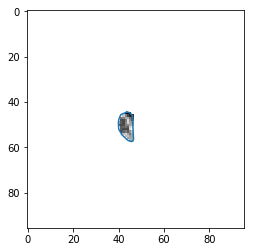

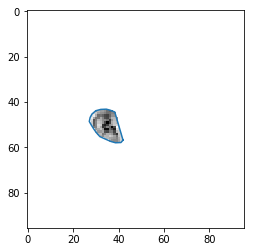

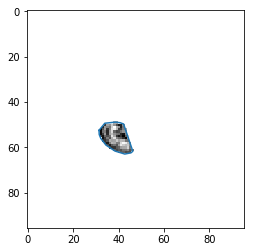

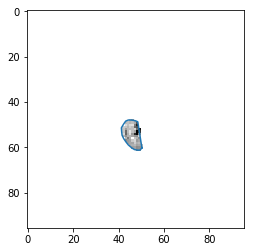

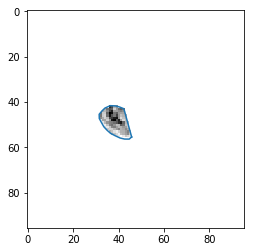

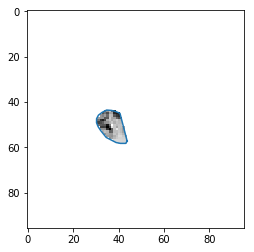

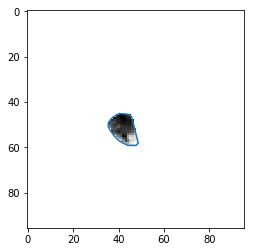

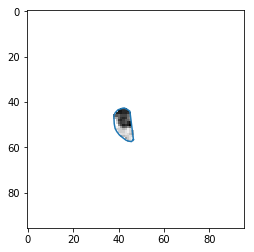

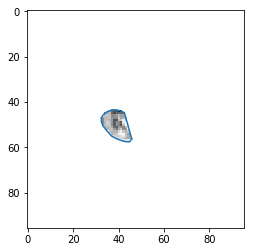

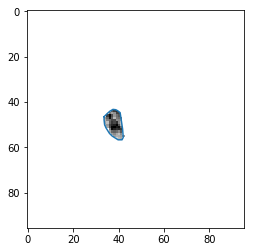

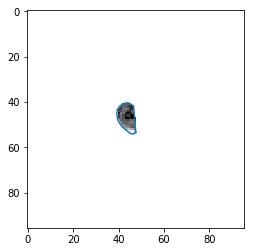

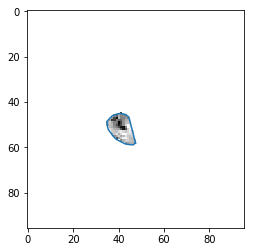

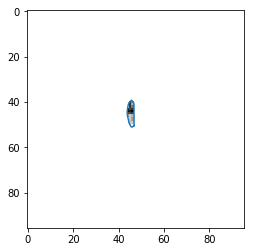

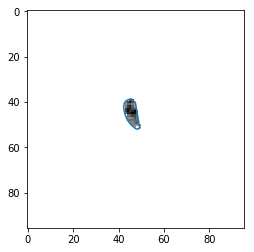

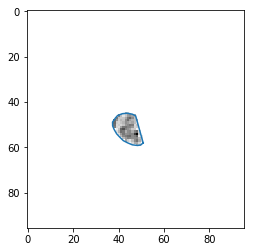

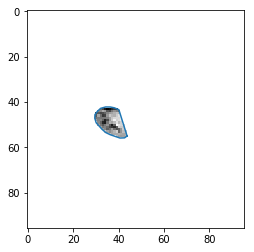

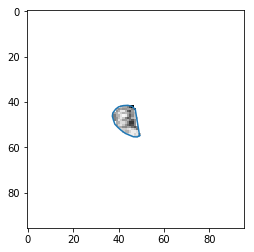

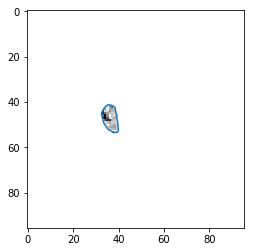

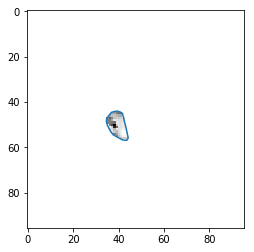

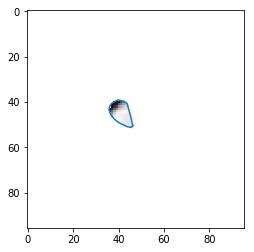

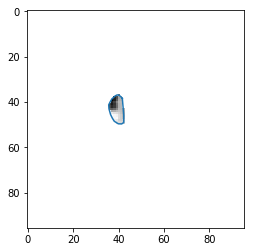

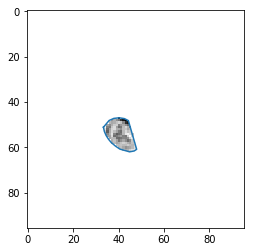

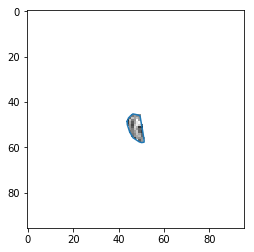

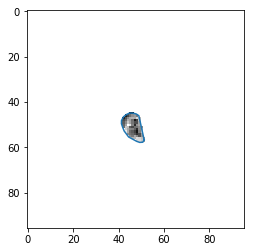

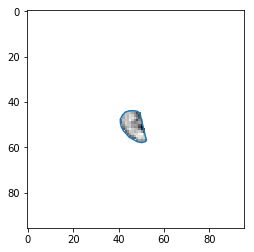

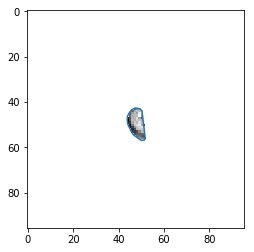

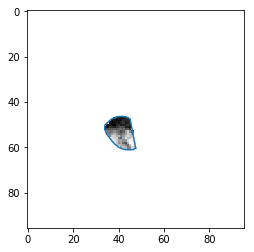

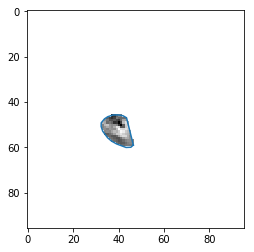

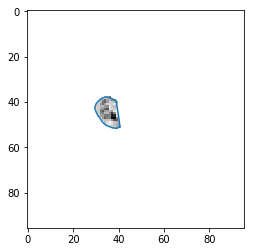

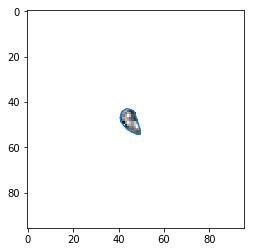

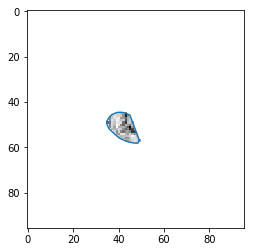

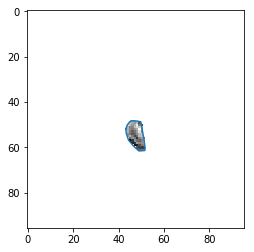

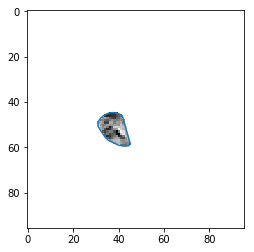

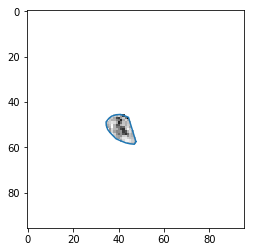

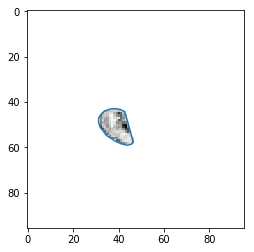

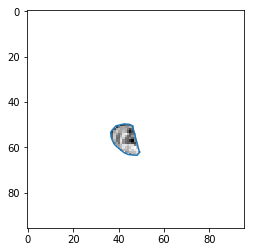

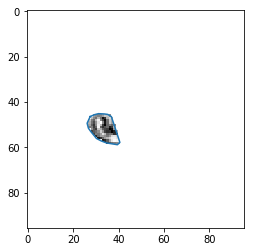

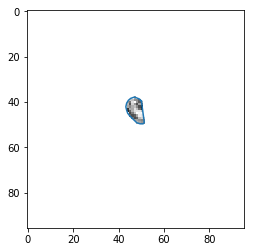

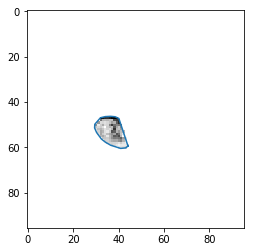

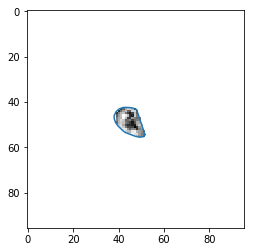

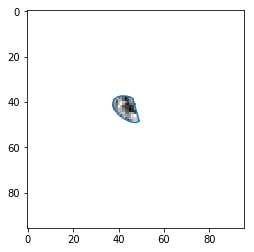

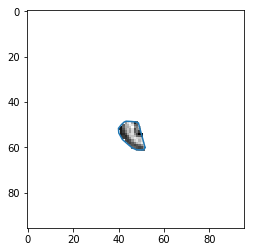

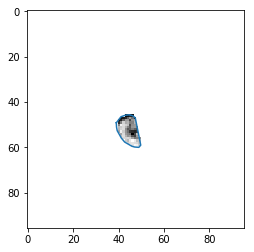

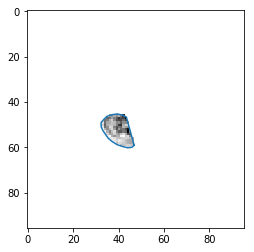

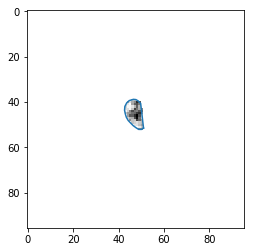

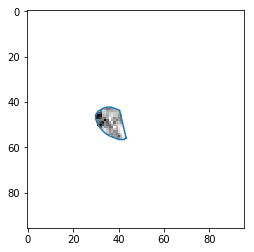

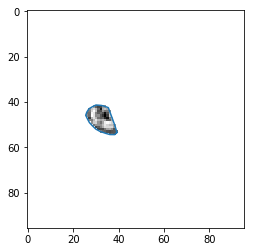

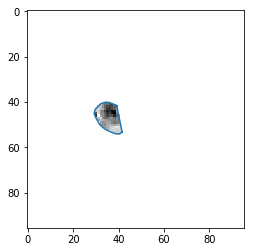

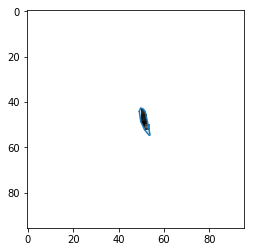

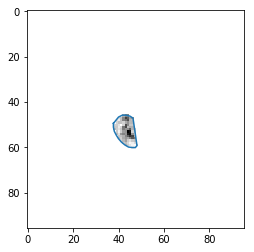

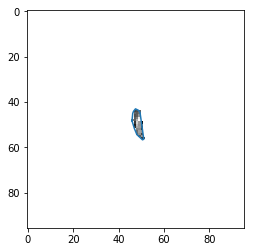

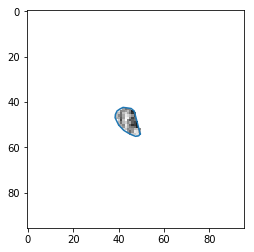

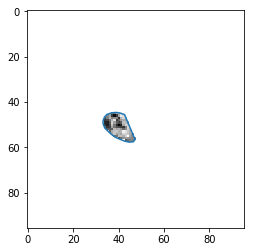

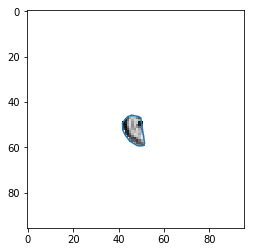

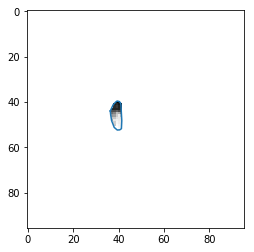

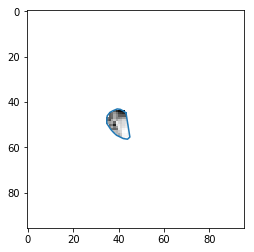

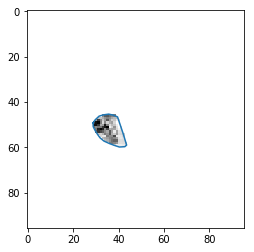

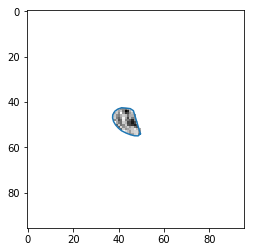

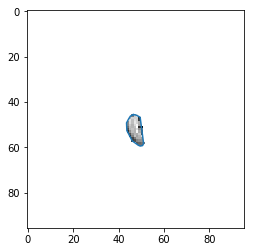

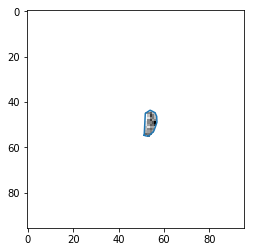

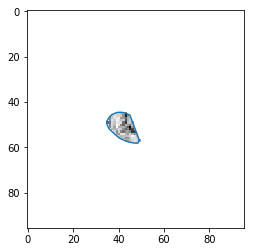

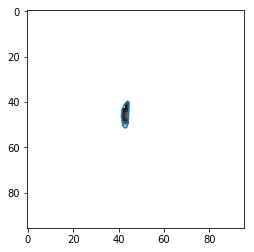

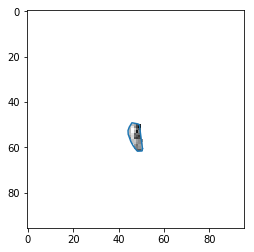

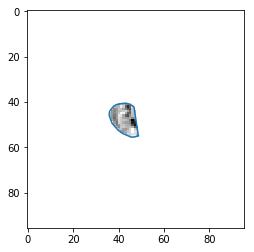

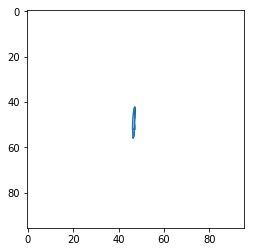

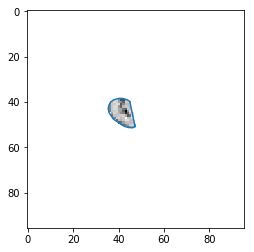

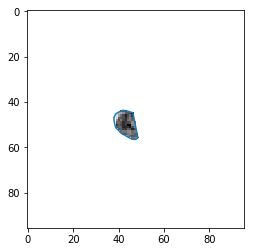

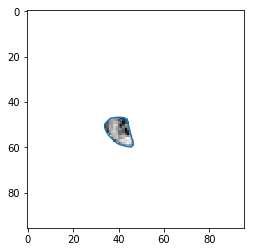

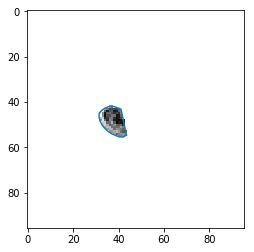

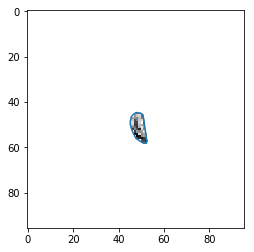

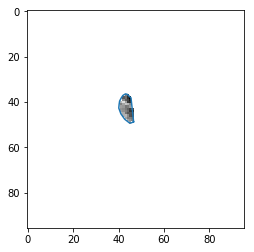

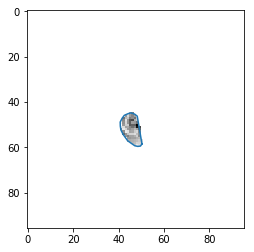

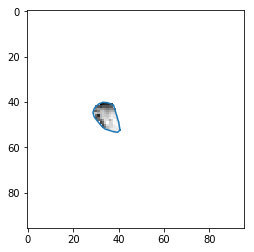

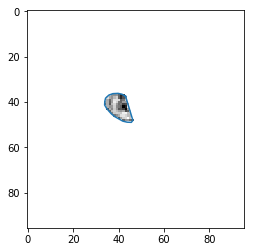

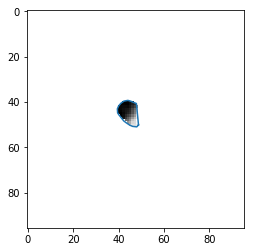

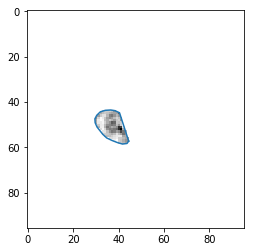

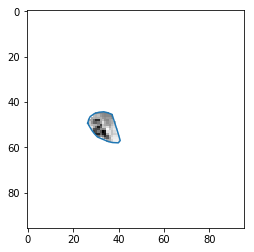

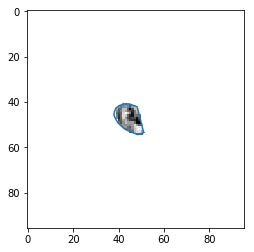

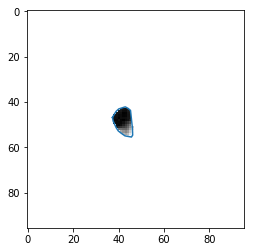

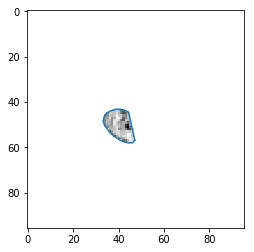

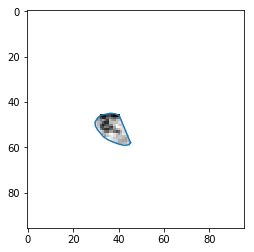

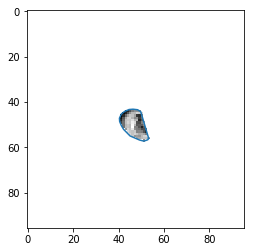

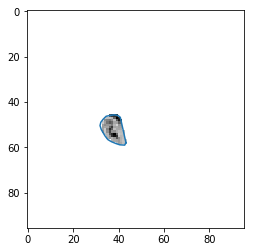

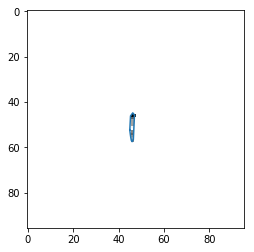

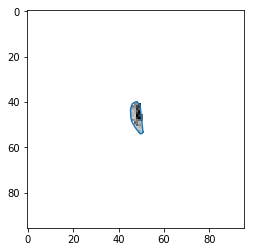

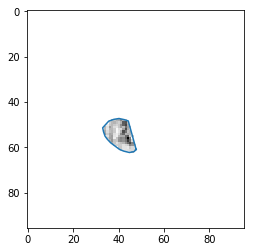

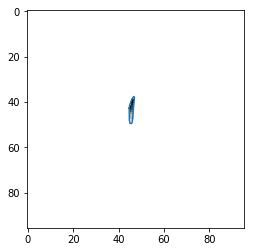

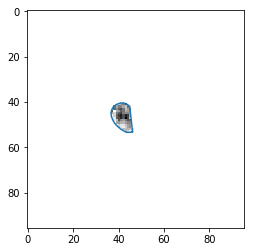

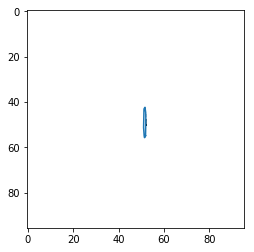

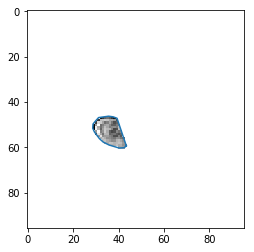

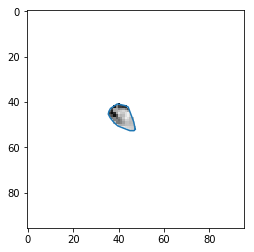

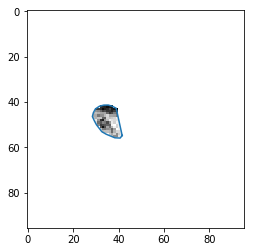

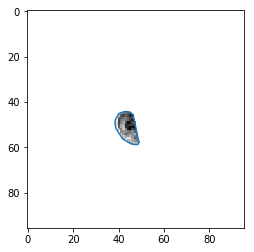

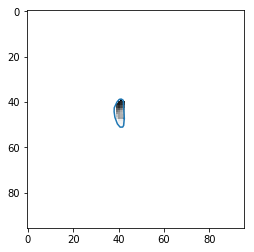

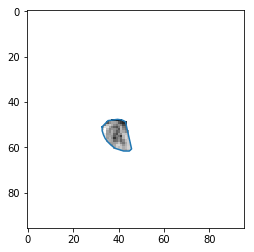

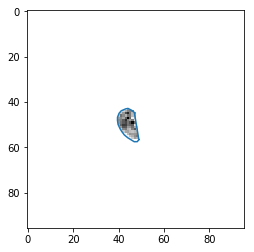

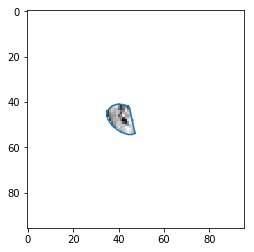

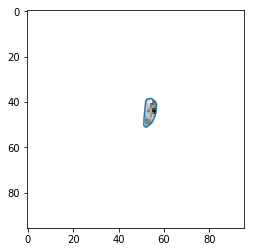

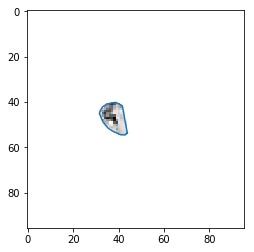

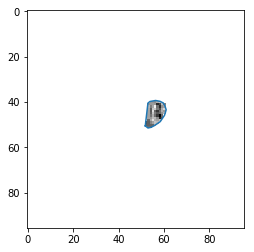

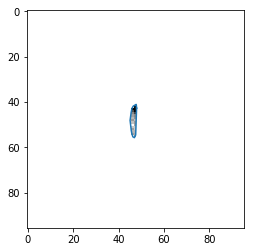

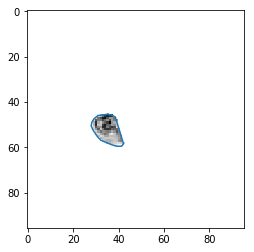

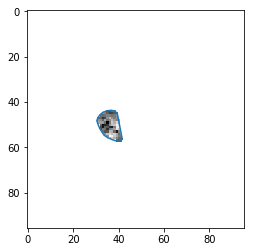

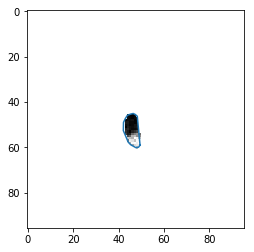

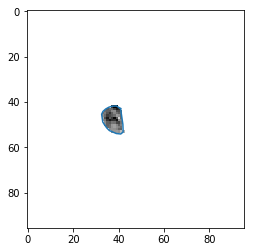

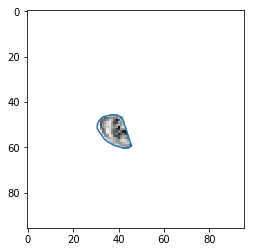

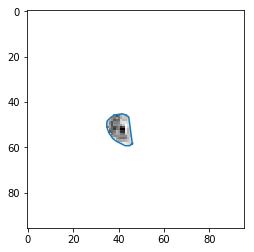

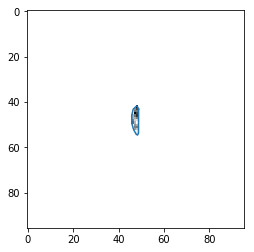

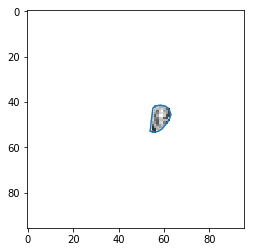

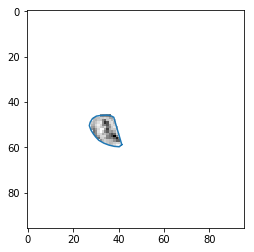

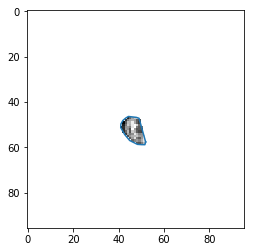

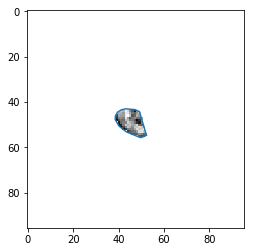

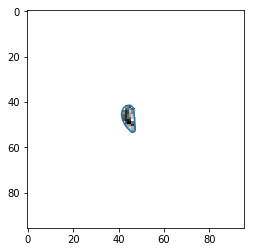

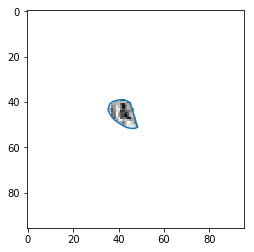

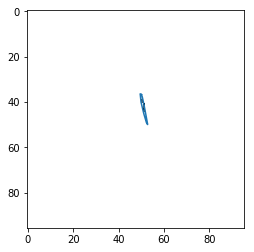

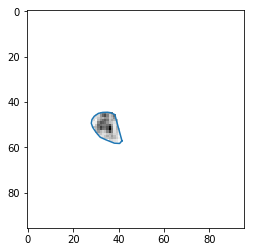

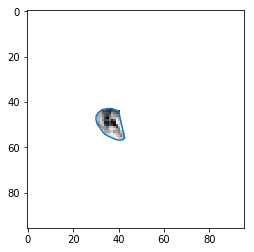

In [92]:
move = 48
nr, nc = (96, 96)
ygrid, xgrid = np.mgrid[:nr, :nc]
xypix = np.vstack((xgrid.ravel(), ygrid.ravel())).T

for i, ear in enumerate(test_ears):
    hull = ConvexHull(ear)
    hull_idx = ordered_hull_idx_2d(hull)
    # Close the polygon
    hull_idx = np.r_[hull_idx, hull_idx[0]]

    # Plot the points
    hull_pts = ear[hull_idx]
    realx = hull_pts[:, 0] * move + move
    realy = hull_pts[:, 1] * move + move

    xycrop = np.vstack((realx, realy)).T

    img = X[i].reshape((96, 96))*255
    # construct a Path from the vertices
    pth = Path(xycrop, closed=False)

    # test which pixels fall within the path
    mask = pth.contains_points(xypix)

    # reshape to the same size as the image
    mask = mask.reshape((96, 96))
    #print(mask)
    # create a masked array
    masked = np.ma.masked_array(img, ~mask)
    plt.imshow(masked, cmap=plt.cm.gray)
    plt.plot(realx, realy, '-')
    plt.savefig('/tmp/masked_{}.png'.format(str(names[i])))
    plt.show()

In [ ]:
%matplotlib inline
import cv2

ear_cascade = cv2.CascadeClassifier('files/cascade_lateral_ears_opencv.xml')

img = cv2.imread('files/face_db_selection/106MVC-001F.JPG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ears = ear_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=2) #, minSize=(10, 10), maxSize=(200, 200))
print ears
for (x,y,w,h) in ears:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
cv2.imwrite('/tmp/test.jpg',img)

fig = plt.figure(figsize=(10, 10))
plt.imshow(img)